In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\raghu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raghu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def load_and_preprocess_data(file_path: str) -> pd.DataFrame:
    """Load and preprocess the DBLP data."""
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                paper = json.loads(line.strip())
                data.append(paper)
            except json.JSONDecodeError:
                continue
    
    df = pd.DataFrame(data)
    # Clean text: combine title and abstract if available
    df['text'] = df['title'].fillna('')
    if 'abstract' in df.columns:
        df['text'] += ' ' + df['abstract'].fillna('')
    
    return df

def preprocess_text(text: str) -> str:
    """Preprocess text by removing stopwords and tokenizing."""
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalnum() and t not in stop_words]
    return ' '.join(tokens)

In [3]:
def perform_topic_modeling(texts: List[str], n_topics: int = 10):
    """Perform LDA topic modeling on the texts."""
    # Create document-term matrix
    vectorizer = CountVectorizer(max_features=5000, stop_words='english')
    doc_term_matrix = vectorizer.fit_transform(texts)
    
    # Perform LDA
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    topic_distributions = lda.fit_transform(doc_term_matrix)
    
    # Get top words for each topic
    feature_names = vectorizer.get_feature_names_out()
    top_words = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-10:-1]
        top_words.append([feature_names[i] for i in top_words_idx])
    
    return topic_distributions, top_words

def cluster_and_visualize_pca(topic_distributions: np.ndarray, n_clusters: int = 5):
    """Perform clustering and PCA for visualization."""
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(topic_distributions)
    
    # Perform PCA for visualization
    pca = PCA(n_components=2)
    topic_pca = pca.fit_transform(topic_distributions)
    
    # Calculate explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    
    return clusters, topic_pca, explained_variance

Processing file: dblp-ref/dblp-ref-0.json
Processing file: dblp-ref/dblp-ref-1.json
Processing file: dblp-ref/dblp-ref-2.json
Processing file: dblp-ref/dblp-ref-3.json
Total number of papers: 3079007
Performing topic modeling...
Performing clustering and PCA visualization...


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


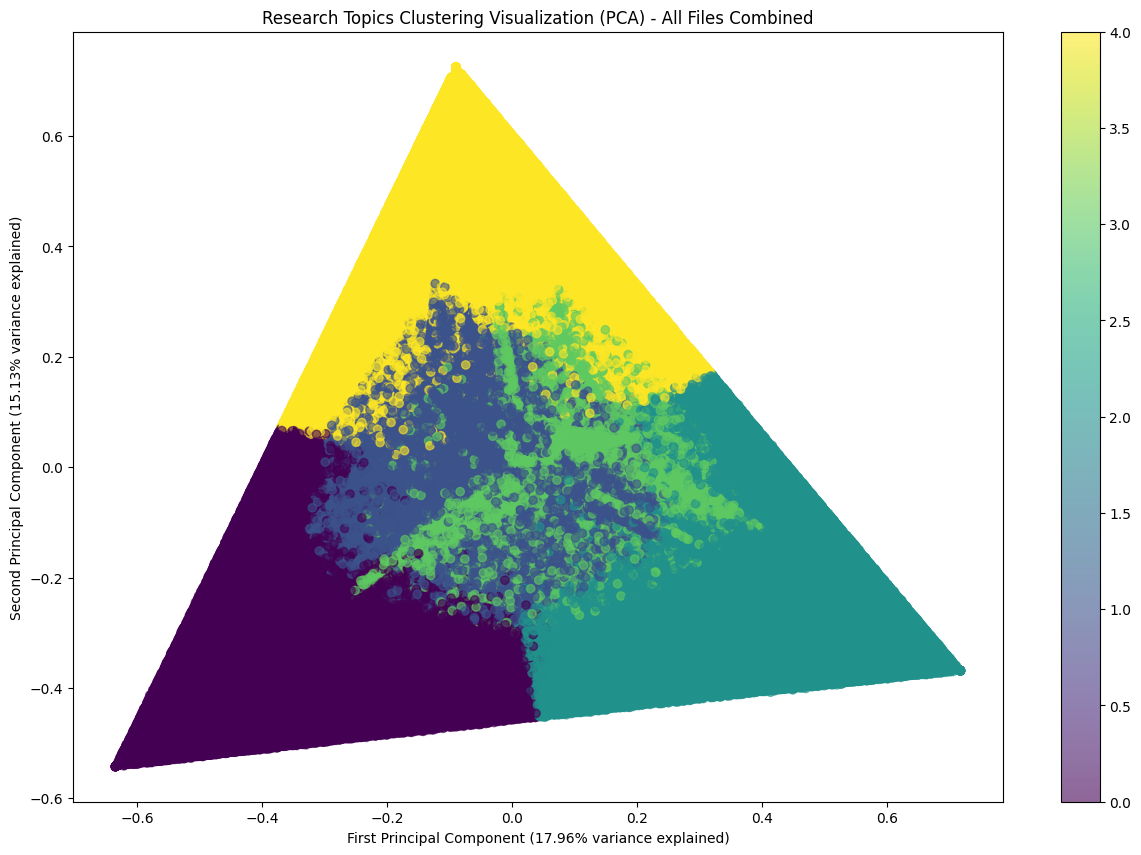


Top words for each topic:
Topic 1: problem, algorithm, problems, graph, paper, number, set, algorithms, method
Topic 2: research, learning, study, paper, design, software, development, information, use
Topic 3: network, control, networks, paper, proposed, model, routing, nodes, systems
Topic 4: model, data, analysis, using, used, results, study, method, models
Topic 5: algorithm, proposed, method, based, using, estimation, error, paper, performance
Topic 6: model, systems, language, models, paper, approach, based, using, logic
Topic 7: performance, data, time, memory, parallel, paper, scheduling, applications, systems
Topic 8: data, image, method, using, based, images, classification, results, detection
Topic 9: power, channel, energy, wireless, performance, proposed, paper, scheme, transmission
Topic 10: data, information, web, user, users, service, services, security, paper


In [4]:
def analyze_multiple_files(file_paths: List[str]):
    """Analyze multiple DBLP JSON files and combine results."""
    
    # Initialize empty list to store combined data
    combined_df = pd.DataFrame()
    
    # Process each file and combine the data
    for file_path in file_paths:
        print(f"Processing file: {file_path}")
        df = load_and_preprocess_data(file_path)
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    # Process the combined dataset
    print(f"Total number of papers: {len(combined_df)}")
    combined_df['processed_text'] = combined_df['text'].apply(preprocess_text)
    
    # Perform topic modeling on combined data
    print("Performing topic modeling...")
    topic_distributions, top_words = perform_topic_modeling(combined_df['processed_text'])
    
    # Perform clustering and PCA visualization
    print("Performing clustering and PCA visualization...")
    clusters, topic_pca, explained_variance = cluster_and_visualize_pca(topic_distributions)
    
    # Create visualization
    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(topic_pca[:, 0], topic_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('Research Topics Clustering Visualization (PCA) - All Files Combined')
    plt.xlabel(f'First Principal Component ({explained_variance[0]:.2%} variance explained)')
    plt.ylabel(f'Second Principal Component ({explained_variance[1]:.2%} variance explained)')
    plt.show()
    
    # Print top words for each topic
    print("\nTop words for each topic:")
    for idx, words in enumerate(top_words):
        print(f"Topic {idx + 1}: {', '.join(words)}")
    
    return {
        'dataframe': combined_df,
        'topic_distributions': topic_distributions,
        'clusters': clusters,
        'top_words': top_words,
        'pca_coordinates': topic_pca,
        'explained_variance': explained_variance
    }

# Usage example
if __name__ == "__main__":
    file_paths = [
        "dblp-ref/dblp-ref-0.json",
        "dblp-ref/dblp-ref-1.json",
        "dblp-ref/dblp-ref-2.json",
        "dblp-ref/dblp-ref-3.json"
    ]
    
    results = analyze_multiple_files(file_paths)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\raghu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raghu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Processing file: dblp-ref/dblp-ref-0.json
Processing file: dblp-ref/dblp-ref-1.json
Processing file: dblp-ref/dblp-ref-2.json
Processing file: dblp-ref/dblp-ref-3.json
Preprocessing texts...
Performing topic modeling...
Creating document-term matrix...
Vocabulary size: 10000
Fitting LDA model...
Analyzing PCA components...


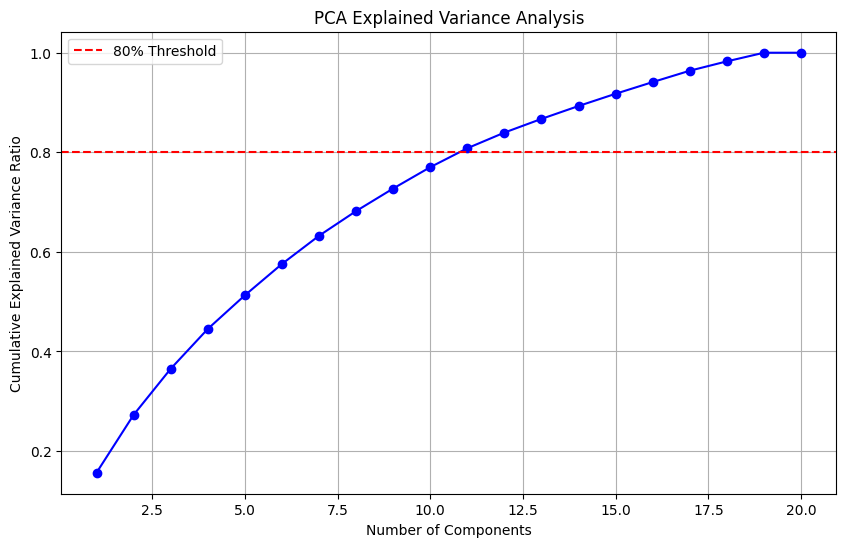

h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


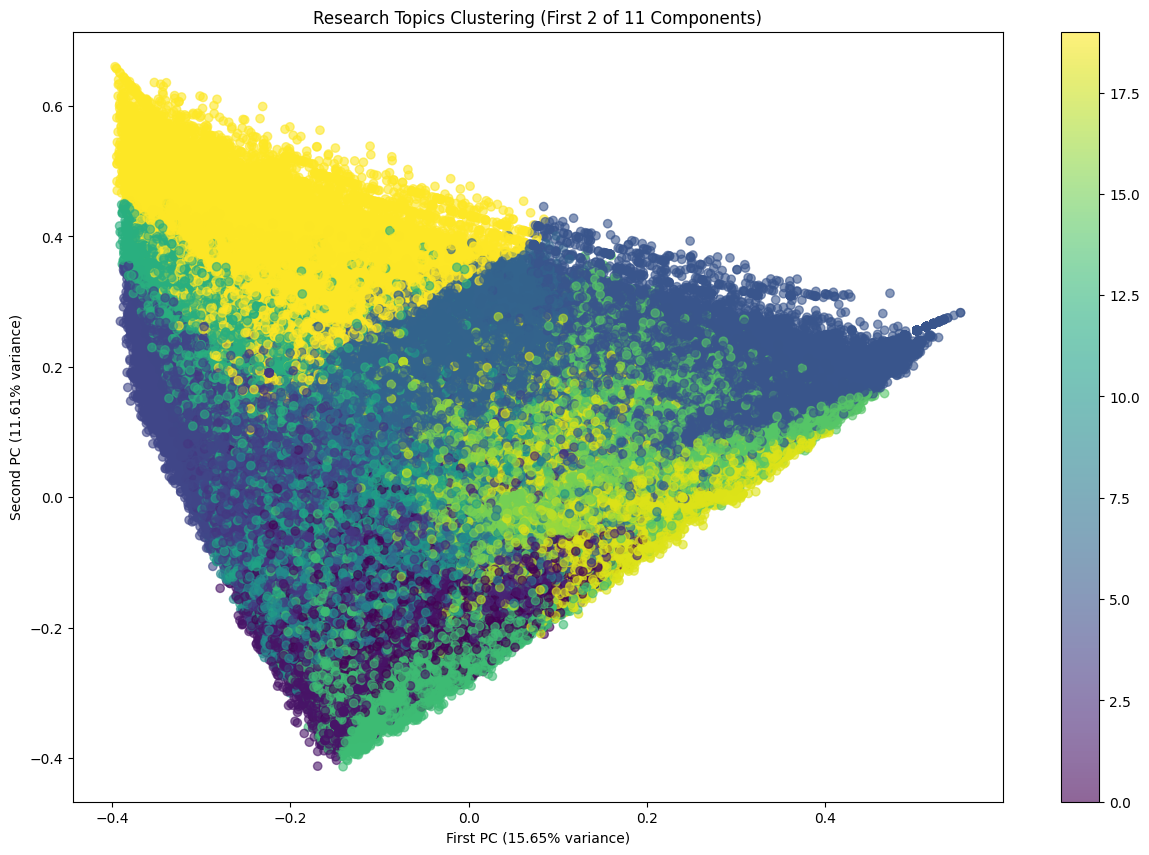


Top words for each topic (with weights):
Topic 1: systems(222072.0996), fuzzy(180701.5466), programming(173312.7096), properties(149473.4131), theory(141386.7776), set(129820.3585), logic(127289.3407), state(124500.4408), models(124411.8326), structure(121393.2171), class(119285.9726), functions(102581.0268), representation(95722.1534), also(94149.5656)
Topic 2: information(244665.4704), flow(128184.2624), content(119531.7618), digital(106540.7889), online(101627.3464), text(94428.4841), mining(90842.0045), community(73162.1498), documents(61825.0987), markov(60192.2769), document(58596.9224), language(55707.0912), survey(52403.38), last(44783.5367)
Topic 3: learning(451130.4623), models(264076.6361), dynamic(230737.7861), neural(177575.5244), decision(164797.6765), modeling(157955.6882), simulation(66079.1686), networks(63230.1254), configuration(56808.0634), supply(56472.5853), static(54632.558), chain(53360.3754), hybrid(52710.0943), knowledge(49902.8158)
Topic 4: network(777709.8)

In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

def get_custom_stop_words():
    """Get custom stop words for academic papers."""
    academic_stop_words = {
        # Common paper structure words
        'paper', 'article', 'journal', 'conference', 'proceedings',
        'abstract', 'introduction', 'conclusion', 'references',
        
        # Common methodology words
        'method', 'approach', 'technique', 'methodology', 'framework',
        'algorithm', 'model', 'system', 'process', 'procedure',
        
        # Common result words
        'results', 'analysis', 'evaluation', 'performance', 'experimental',
        'implementation', 'proposed', 'presented', 'demonstrated',
        
        # Common academic phrases
        'research', 'study', 'work', 'literature', 'previous',
        'current', 'existing', 'recent', 'novel', 'new',
        
        # Common verbs
        'using', 'based', 'used', 'show', 'shown', 'shows',
        'propose', 'present', 'describe', 'discuss', 'evaluate',
        
        # Common adjectives
        'different', 'various', 'several', 'many', 'multiple',
        'effective', 'efficient', 'better', 'best', 'improved'
    }
    return academic_stop_words.union(set(stopwords.words('english')))

def load_and_preprocess_data(file_path: str) -> pd.DataFrame:
    """Load and preprocess the DBLP data."""
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                paper = json.loads(line.strip())
                data.append(paper)
            except json.JSONDecodeError:
                continue
    
    df = pd.DataFrame(data)
    df['text'] = df['title'].fillna('')
    if 'abstract' in df.columns:
        df['text'] += ' ' + df['abstract'].fillna('')
    
    return df

def preprocess_text(text: str) -> str:
    """Enhanced preprocessing with custom stop words."""
    stop_words = get_custom_stop_words()
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if (
        t.isalpha() and 
        len(t) > 2 and 
        t not in stop_words
    )]
    return ' '.join(tokens)

def perform_topic_modeling(texts: List[str], n_topics: int = 20):
    """Enhanced topic modeling for research papers."""
    vectorizer = CountVectorizer(
        max_features=10000,
        min_df=10,   # Remove very rare terms
        max_df=0.3,  # Remove very common terms
        token_pattern=r'(?u)\b[A-Za-z]{3,}\b'
    )
    
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=25,
        learning_method='online',
        batch_size=256,
        n_jobs=1,
        random_state=42
    )
    
    print("Creating document-term matrix...")
    doc_term_matrix = vectorizer.fit_transform(texts)
    print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")
    
    print("Fitting LDA model...")
    topic_distributions = lda.fit_transform(doc_term_matrix)
    
    feature_names = vectorizer.get_feature_names_out()
    top_words = []
    for topic_idx, topic in enumerate(lda.components_):
        top_word_indices = topic.argsort()[:-15:-1]
        words_weights = [(feature_names[i], round(topic[i], 4)) 
                        for i in top_word_indices]
        top_words.append(words_weights)
    
    return topic_distributions, top_words

def analyze_pca_components(topic_distributions):
    """Analyze PCA components and their explained variance."""
    pca = PCA()
    pca.fit(topic_distributions)
    
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), 
            cumulative_variance_ratio, 'bo-')
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA Explained Variance Analysis')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    n_components_80 = np.argmax(cumulative_variance_ratio >= 0.8) + 1
    
    return n_components_80, cumulative_variance_ratio

def analyze_research_topics(file_paths: List[str], n_topics: int = 20):
    """Enhanced analysis with better preprocessing and PCA analysis."""
    combined_df = pd.DataFrame()
    for file_path in file_paths:
        print(f"Processing file: {file_path}")
        df = load_and_preprocess_data(file_path)
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    print("Preprocessing texts...")
    combined_df['processed_text'] = combined_df['text'].apply(preprocess_text)
    
    print("Performing topic modeling...")
    topic_distributions, top_words = perform_topic_modeling(
        combined_df['processed_text'], 
        n_topics=n_topics
    )
    
    print("Analyzing PCA components...")
    n_components_80, variance_ratio = analyze_pca_components(topic_distributions)
    
    pca = PCA(n_components=n_components_80)
    topic_pca = pca.fit_transform(topic_distributions)
    
    kmeans = KMeans(n_clusters=n_topics, random_state=42)
    clusters = kmeans.fit_predict(topic_pca)
    
    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(topic_pca[:, 0], topic_pca[:, 1], 
                         c=clusters, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(f'Research Topics Clustering (First 2 of {n_components_80} Components)')
    plt.xlabel(f'First PC ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Second PC ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.show()
    
    print("\nTop words for each topic (with weights):")
    for idx, words_weights in enumerate(top_words):
        words_str = ', '.join([f"{word}({weight})" for word, weight in words_weights])
        print(f"Topic {idx + 1}: {words_str}")
    
    return {
        'dataframe': combined_df,
        'topic_distributions': topic_distributions,
        'pca_coordinates': topic_pca,
        'clusters': clusters,
        'top_words': top_words,
        'n_components_80': n_components_80,
        'variance_ratio': variance_ratio
    }

if __name__ == "__main__":
    file_paths = [
        "dblp-ref/dblp-ref-0.json",
        "dblp-ref/dblp-ref-1.json",
        "dblp-ref/dblp-ref-2.json",
        "dblp-ref/dblp-ref-3.json"
    ]
    
    results = analyze_research_topics(file_paths, n_topics=20)

Fresh Run

In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from multiprocessing import Pool, cpu_count
from functools import lru_cache
from scipy.sparse import csr_matrix
from scipy.cluster.hierarchy import linkage, dendrogram
import pickle
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from numba import jit
import sys
import os
import psutil
import traceback

# Check for required packages
required_packages = {
    'numpy', 'pandas', 'sklearn', 'matplotlib', 'seaborn', 
    'nltk', 'scipy', 'gensim', 'numba', 'multiprocessing'
}

missing_packages = [package for package in required_packages if package not in sys.modules]

if missing_packages:
    print(f"Missing packages: {missing_packages}")
    print("Please install them using: pip install [package_name]")
    sys.exit(1)

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

@lru_cache(maxsize=None)
def get_custom_stop_words():
    """Get custom stop words for academic papers."""
    academic_stop_words = {
        # Common paper structure words
        'paper', 'article', 'journal', 'conference', 'proceedings',
        'abstract', 'introduction', 'conclusion', 'references',
        
        # Common methodology words
        'method', 'approach', 'technique', 'methodology', 'framework',
        'algorithm', 'model', 'system', 'process', 'procedure',
        
        # Common result words
        'results', 'analysis', 'evaluation', 'performance', 'experimental',
        'implementation', 'proposed', 'presented', 'demonstrated',
        
        # Common academic phrases
        'research', 'study', 'work', 'literature', 'previous',
        'current', 'existing', 'recent', 'novel', 'new',
        
        # Common verbs
        'using', 'based', 'used', 'show', 'shown', 'shows',
        'propose', 'present', 'describe', 'discuss', 'evaluate',
        
        # Common adjectives
        'different', 'various', 'several', 'many', 'multiple',
        'effective', 'efficient', 'better', 'best', 'improved'
    }
    return academic_stop_words.union(set(stopwords.words('english')))

def load_and_preprocess_data(file_path: str) -> pd.DataFrame:
    """Load and preprocess the DBLP data."""
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                paper = json.loads(line.strip())
                data.append(paper)
            except json.JSONDecodeError:
                continue
    
    df = pd.DataFrame(data)
    df['text'] = df['title'].fillna('')
    if 'abstract' in df.columns:
        df['text'] += ' ' + df['abstract'].fillna('')
    
    return df

def preprocess_text(text: str) -> str:
    """Enhanced preprocessing with custom stop words."""
    stop_words = get_custom_stop_words()
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if (
        t.isalpha() and 
        len(t) > 2 and 
        t not in stop_words
    )]
    return ' '.join(tokens)

def process_file(file_path):
    df = load_and_preprocess_data(file_path)
    df['processed_text'] = df['text'].apply(preprocess_text)
    return df

def perform_topic_modeling(texts: List[str], n_topics: int = 20):
    """Enhanced topic modeling for research papers."""
    vectorizer = CountVectorizer(
        max_features=10000,
        min_df=10,   # Remove very rare terms
        max_df=0.3,  # Remove very common terms
        token_pattern=r'(?u)\b[A-Za-z]{3,}\b'
    )
    
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=25,
        learning_method='online',
        batch_size=256,
        n_jobs=-1,
        random_state=42
    )
    
    print("Creating document-term matrix...")
    doc_term_matrix = vectorizer.fit_transform(texts)
    doc_term_matrix = csr_matrix(doc_term_matrix)  # Ensure it's sparse
    print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")
    
    print("Fitting LDA model...")
    topic_distributions = lda.fit_transform(doc_term_matrix)
    
    feature_names = vectorizer.get_feature_names_out()
    top_words = []
    for topic_idx, topic in enumerate(lda.components_):
        top_word_indices = topic.argsort()[:-15:-1]
        words_weights = [(feature_names[i], round(topic[i], 4)) 
                        for i in top_word_indices]
        top_words.append(words_weights)
    
    return topic_distributions, top_words, lda, vectorizer

def analyze_pca_components(topic_distributions):
    """Analyze PCA components and their explained variance."""
    pca = PCA()
    pca.fit(topic_distributions)
    
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), 
            cumulative_variance_ratio, 'bo-')
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA Explained Variance Analysis')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    n_components_80 = np.argmax(cumulative_variance_ratio >= 0.8) + 1
    
    return n_components_80, cumulative_variance_ratio

@jit(nopython=True)
def fast_cosine_similarity(vec1, vec2):
    dot = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot / (norm1 * norm2)

def visualize_topic_relationships(topic_distributions):
    topic_correlations = np.corrcoef(topic_distributions.T)
    linkage_matrix = linkage(topic_correlations, 'ward')
    
    plt.figure(figsize=(15, 10))
    dendrogram(linkage_matrix)
    plt.title('Hierarchical Clustering of Research Topics')
    plt.xlabel('Topic Index')
    plt.ylabel('Distance')
    plt.show()

def analyze_topic_evolution(df, topic_distributions):
    try:
        if 'year' not in df.columns:
            print("Warning: 'year' column not found in dataframe")
            return
            
        df['year'] = pd.to_datetime(df['year'], format='%Y', errors='coerce').dt.year
        if df['year'].isna().all():
            print("Warning: No valid years found in the data")
            return
        
        yearly_topics = pd.DataFrame({
            'year': df['year'],
            **{f'Topic_{i+1}': topic_distributions[:, i] for i in range(topic_distributions.shape[1])}
        }).groupby('year').mean()
        
        plt.figure(figsize=(15, 8))
        for topic in range(topic_distributions.shape[1]):
            plt.plot(yearly_topics.index, yearly_topics[f'Topic_{topic+1}'], 
                    label=f'Topic {topic+1}')
        
        plt.title('Evolution of Research Topics Over Time')
        plt.xlabel('Year')
        plt.ylabel('Topic Proportion')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in analyze_topic_evolution: {str(e)}")

def evaluate_topic_coherence(texts, topic_model, vectorizer):
    dictionary = Dictionary([text.split() for text in texts])
    corpus = [dictionary.doc2bow(text.split()) for text in texts]
    
    coherence_model = CoherenceModel(
        topics=topic_model.components_,
        texts=[text.split() for text in texts],
        dictionary=dictionary,
        coherence='c_v'
    )
    
    return coherence_model.get_coherence()

def analyze_research_topics(file_paths: List[str], n_topics: int = 20):
    """Enhanced analysis with better preprocessing and PCA analysis."""
    # Use multiprocessing to load and preprocess data
    with Pool(processes=cpu_count()) as pool:
        dfs = pool.map(process_file, file_paths)
    
    combined_df = pd.concat(dfs, ignore_index=True)
    
    print("Performing topic modeling...")
    topic_distributions, top_words, lda_model, vectorizer = perform_topic_modeling(
        combined_df['processed_text'], 
        n_topics=n_topics
    )
    
    print("Analyzing PCA components...")
    n_components_80, variance_ratio = analyze_pca_components(topic_distributions)
    
    pca = PCA(n_components=n_components_80)
    topic_pca = pca.fit_transform(topic_distributions)
    
    kmeans = MiniBatchKMeans(n_clusters=n_topics, random_state=42, batch_size=1000)
    clusters = kmeans.fit_predict(topic_pca)
    
    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(topic_pca[:, 0], topic_pca[:, 1], 
                         c=clusters, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(f'Research Topics Clustering (First 2 of {n_components_80} Components)')
    plt.xlabel(f'First PC ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Second PC ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.show()
    
    print("\nTop words for each topic (with weights):")
    for idx, words_weights in enumerate(top_words):
        words_str = ', '.join([f"{word}({weight})" for word, weight in words_weights])
        print(f"Topic {idx + 1}: {words_str}")
    
    return {
        'dataframe': combined_df,
        'topic_distributions': topic_distributions,
        'pca_coordinates': topic_pca,
        'clusters': clusters,
        'top_words': top_words,
        'n_components_80': n_components_80,
        'variance_ratio': variance_ratio,
        'lda_model': lda_model,
        'vectorizer': vectorizer
    }

def check_memory():
    memory = psutil.virtual_memory()
    print(f"Available memory: {memory.available / 1024 / 1024 / 1024:.2f} GB")
    if memory.available < 4 * 1024 * 1024 * 1024:  # Less than 4GB
        print("Warning: Low memory available")
        return False
    return True

def verify_files(file_paths):
    missing_files = [path for path in file_paths if not os.path.exists(path)]
    
    if missing_files:
        print(f"Missing files: {missing_files}")
        return False
    return True

def ensure_output_directory():
    output_dir = 'output'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir

if __name__ == "__main__":
    file_paths = [
        "dblp-ref/dblp-ref-0.json",
        "dblp-ref/dblp-ref-1.json",
        "dblp-ref/dblp-ref-2.json",
        "dblp-ref/dblp-ref-3.json"
    ]
    
    # Pre-run checks
    if not check_memory():
        sys.exit(1)
    
    if not verify_files(file_paths):
        sys.exit(1)
    
    output_dir = ensure_output_directory()
    
    try:
        results = analyze_research_topics(file_paths, n_topics=20)
        
        # Save results incrementally
        print("Saving results...")
        with open(os.path.join(output_dir, 'research_topics_results.pkl'), 'wb') as f:
            pickle.dump(results, f)
        
        print("Saving topic distributions...")
        np.save(os.path.join(output_dir, 'topic_distributions.npy'), results['topic_distributions'], allow_pickle=False)
        
        print("Saving PCA coordinates...")
        np.save(os.path.join(output_dir, 'pca_coordinates.npy'), results['pca_coordinates'], allow_pickle=False)
        
        print("Performing additional analyses...")
        visualize_topic_relationships(results['topic_distributions'])
        analyze_topic_evolution(results['dataframe'], results['topic_distributions'])
        
        coherence_score = evaluate_topic_coherence(
            results['dataframe']['processed_text'],
            results['lda_model'],
            results['vectorizer']
        )
        print(f"Topic Coherence Score: {coherence_score}")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        traceback.print_exc()

Available memory: 46.62 GB


In [1]:
import json
import pandas as pd
import numpy as np
import os
import logging
import psutil
import multiprocessing
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import nltk
import pickle

# Initialize logging
logging.basicConfig(
    filename='topic_modeling.log',
    filemode='a',
    format='%(asctime)s %(levelname)s: %(message)s',
    level=logging.INFO
)

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Custom stop words
custom_stopwords = set(stopwords.words('english')).union({
    'paper', 'article', 'journal', 'conference', 'proceedings',
    'abstract', 'introduction', 'conclusion', 'references',
    'method', 'approach', 'technique', 'methodology', 'framework',
    'algorithm', 'model', 'system', 'process', 'procedure',
    'results', 'analysis', 'evaluation', 'performance', 'experimental',
    'implementation', 'proposed', 'presented', 'demonstrated',
    'research', 'study', 'work', 'literature', 'previous',
    'current', 'existing', 'recent', 'novel', 'new',
    'using', 'based', 'used', 'show', 'shown', 'shows',
    'propose', 'present', 'describe', 'discuss', 'evaluate',
    'different', 'various', 'several', 'many', 'multiple',
    'effective', 'efficient', 'better', 'best', 'improved'
})

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Tokenize, remove stop words, and lemmatize."""
    result = []
    for token in simple_preprocess(text, deacc=True):
        if token not in custom_stopwords and len(token) > 2:
            lemmatized = lemmatizer.lemmatize(token)
            result.append(lemmatized)
    return result

def load_and_preprocess_data(file_path):
    """Load and preprocess data incrementally."""
    logging.info(f"Processing file: {file_path}")
    processed_texts = []
    titles = []
    years = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc=f"Processing {os.path.basename(file_path)}"):
            try:
                paper = json.loads(line.strip())
                text = paper.get('title', '') + ' ' + paper.get('abstract', '')
                tokens = preprocess_text(text)
                if tokens:
                    processed_texts.append(tokens)
                    titles.append(paper.get('title', ''))
                    years.append(paper.get('year', None))
            except json.JSONDecodeError:
                continue
    return processed_texts, titles, years

def build_dictionary(processed_texts):
    """Create a dictionary for the corpus."""
    logging.info("Building dictionary...")
    dictionary = Dictionary(processed_texts)
    logging.info(f"Initial dictionary size: {len(dictionary)}")
    # Filter out extremes to limit the number of features
    dictionary.filter_extremes(no_below=15, no_above=0.5)
    logging.info(f"Filtered dictionary size: {len(dictionary)}")
    return dictionary

def build_corpus(processed_texts, dictionary):
    """Create a corpus using the dictionary."""
    logging.info("Building corpus...")
    corpus = [dictionary.doc2bow(text) for text in tqdm(processed_texts, desc='Converting texts to BoW')]
    logging.info(f"Corpus size: {len(corpus)} documents")
    return corpus

def train_lda_model(corpus, dictionary, num_topics, passes=1, workers=1):
    """Train LDA model using Gensim's LdaMulticore."""
    logging.info(f"Training LDA model with {num_topics} topics...")
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        chunksize=2000,
        passes=passes,
        alpha='asymmetric',
        eta='auto',
        workers=workers,
        eval_every=1
    )
    logging.info("LDA model training completed.")
    return lda_model

def save_model(lda_model, model_path):
    """Save the LDA model."""
    logging.info(f"Saving LDA model to {model_path}")
    lda_model.save(model_path)

def load_model(model_path):
    """Load the LDA model."""
    logging.info(f"Loading LDA model from {model_path}")
    lda_model = LdaMulticore.load(model_path)
    return lda_model



def compute_coherence(lda_model, texts, dictionary, coherence, sample_size, topn, processes):
    """Compute the coherence score of the model using a sample of texts."""
    logging.info("Computing coherence score...")
    if sample_size and sample_size < len(texts):
        sample_texts = random.sample(texts, sample_size)
        logging.info(f"Sampled {sample_size} texts for coherence computation.")
    else:
        sample_texts = texts
        logging.info("Using all texts for coherence computation.")

    coherence_model_lda = CoherenceModel(
        model=lda_model,
        texts=sample_texts,
        dictionary=dictionary,
        coherence=coherence,
        topn=topn,
        processes=processes
    )
    coherence_score = coherence_model_lda.get_coherence()
    logging.info(f"Coherence Score: {coherence_score}")
    print(f"Coherence Score: {coherence_score}")
    return coherence_score

In [3]:
# Load preprocessed data
with open('preprocessed_data.pkl', 'rb') as f:
    data = pickle.load(f)
all_processed_texts = data['texts']
all_titles = data['titles']
all_years = data['years']

# Load dictionary and corpus
dictionary = Dictionary.load('dictionary.gensim')
with open('corpus.pkl', 'rb') as f:
    corpus = pickle.load(f)

# Load LDA model
lda_model = load_model('lda_model.gensim')

In [4]:
def compute_coherence(lda_model, texts, dictionary, coherence='u_mass', sample_size=10000, topn=10, processes=4):
    """Compute the coherence score of the model using a sample of texts."""
    logging.info("Computing coherence score...")
    
    # Take a smaller sample for faster computation
    sample_size = min(10000, len(texts))
    sample_texts = random.sample(texts, sample_size)
    logging.info(f"Sampled {sample_size} texts for coherence computation.")

    # For c_v measure
    if coherence == 'c_v':
        coherence_model_lda = CoherenceModel(
            model=lda_model,
            texts=sample_texts,
            dictionary=dictionary,
            coherence='c_v',
            topn=topn,
            processes=processes
        )
    # For u_mass measure (faster and still reliable)
    else:
        coherence_model_lda = CoherenceModel(
            model=lda_model,
            corpus=dictionary.doc2bow(text) for text in sample_texts,
            dictionary=dictionary,
            coherence='u_mass',
            processes=processes
        )
    
    coherence_score = coherence_model_lda.get_coherence()
    logging.info(f"Coherence Score ({coherence}): {coherence_score}")
    print(f"Coherence Score ({coherence}): {coherence_score}")
    return coherence_score

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (1483193570.py, line 24)

In [6]:
import random

# Call with much more reasonable parameters
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='u_mass',  # Changed from c_v to u_mass
    sample_size=10000,   # Reduced from 100k to 10k
    topn=10,
    processes=6          # Reduced from 15 to 6
)

Coherence Score: -2.7812694605552264


In [8]:

# Call with much more reasonable parameters
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='u_mass',  # Changed from c_v to u_mass
    sample_size=100000,   # Reduced from 100k to 10k
    topn=10,
    processes=15          # Reduced from 15 to 6
)

Coherence Score: -2.515294871199585


In [10]:

# Call with much more reasonable parameters
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='u_mass',  # Changed from c_v to u_mass
    sample_size=1000000,   # Reduced from 100k to 10k
    topn=10,
    processes=6          # Reduced from 15 to 6
)

Coherence Score: -2.497764514948608


In [11]:

# Call with much more reasonable parameters
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='u_mass',  # Changed from c_v to u_mass
    sample_size=5000000,   # Reduced from 100k to 10k
    topn=10,
    processes=6          # Reduced from 15 to 6
)

Coherence Score: -2.497955033684671


In [12]:
# Try with much smaller sample size for c_v
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='c_v',     # Keep c_v but with smaller sample
    sample_size=2000,    # Dramatically reduced from 100k to 5k
    topn=10,            
    processes=15          # Reduced processes to avoid memory issues
)

Coherence Score: 0.4692260552228074


In [13]:
# Try with much smaller sample size for c_v
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='c_v',     # Keep c_v but with smaller sample
    sample_size=5000,    # Dramatically reduced from 100k to 5k
    topn=10,            
    processes=15          # Reduced processes to avoid memory issues
)

Coherence Score: 0.5264024232886716


In [14]:
# Try with much smaller sample size for c_v
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='c_v',     # Keep c_v but with smaller sample
    sample_size=10000,    # Dramatically reduced from 100k to 5k
    topn=10,            
    processes=15          # Reduced processes to avoid memory issues
)

Coherence Score: 0.5637034845323519


In [15]:
# Try with much smaller sample size for c_v
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='c_v',     # Keep c_v but with smaller sample
    sample_size=20000,    # Dramatically reduced from 100k to 5k
    topn=10,            
    processes=15          # Reduced processes to avoid memory issues
)

Coherence Score: 0.5842678908031396


In [16]:
# Try with much smaller sample size for c_v
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='c_v',     # Keep c_v but with smaller sample
    sample_size=40000,    # Dramatically reduced from 100k to 5k
    topn=10,            
    processes=15          # Reduced processes to avoid memory issues
)

Coherence Score: 0.5900645471663376


In [17]:
# Try with much smaller sample size for c_v
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='c_v',     # Keep c_v but with smaller sample
    sample_size=50000,    # Dramatically reduced from 100k to 5k
    topn=10,            
    processes=15          # Reduced processes to avoid memory issues
)

Coherence Score: 0.5946690052729955


In [18]:
# Try with much smaller sample size for c_v
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='c_v',     # Keep c_v but with smaller sample
    sample_size=65000,    # Dramatically reduced from 100k to 5k
    topn=10,            
    processes=15          # Reduced processes to avoid memory issues
)

Coherence Score: 0.5997363248271783


In [19]:
# Try with much smaller sample size for c_v
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='c_v',     # Keep c_v but with smaller sample
    sample_size=40000,    # Dramatically reduced from 100k to 5k
    topn=15,            
    processes=15          # Reduced processes to avoid memory issues
)

Coherence Score: 0.5577513564219068


In [20]:
# Try with much smaller sample size for c_v
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='c_v',     # Keep c_v but with smaller sample
    sample_size=75000,    # Dramatically reduced from 100k to 5k
    topn=10,            
    processes=15          # Reduced processes to avoid memory issues
)

Coherence Score: 0.5932725978157534


In [21]:
# Try with much smaller sample size for c_v
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='c_v',     # Keep c_v but with smaller sample
    sample_size=75000,    # Dramatically reduced from 100k to 5k
    topn=15,            
    processes=15          # Reduced processes to avoid memory issues
)

Coherence Score: 0.56415313955036


In [32]:
# Try with much smaller sample size for c_v
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='c_v',     # Keep c_v but with smaller sample
    sample_size=100000,    # Dramatically reduced from 100k to 5k
    topn=10,            
    processes=15          # Reduced processes to avoid memory issues
)

Coherence Score: 0.5948196545445815


In [33]:
# Try with much smaller sample size for c_v
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='c_v',     # Keep c_v but with smaller sample
    sample_size=100000,    # Dramatically reduced from 100k to 5k
    topn=15,            
    processes=15          # Reduced processes to avoid memory issues
)

Coherence Score: 0.5694851348869113


In [34]:
# Try with much smaller sample size for c_v
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='c_v',     # Keep c_v but with smaller sample
    sample_size=200000,    # Dramatically reduced from 100k to 5k
    topn=10,            
    processes=15          # Reduced processes to avoid memory issues
)

Coherence Score: 0.6022412649055783


In [35]:
# Try with much smaller sample size for c_v
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='c_v',     # Keep c_v but with smaller sample
    sample_size=500000,    # Dramatically reduced from 100k to 5k
    topn=10,            
    processes=15          # Reduced processes to avoid memory issues
)

Coherence Score: 0.6029399821034661


In [36]:
# Try with much smaller sample size for c_v
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='c_v',     # Keep c_v but with smaller sample
    sample_size=1000000,    # Dramatically reduced from 100k to 5k
    topn=10,            
    processes=15          # Reduced processes to avoid memory issues
)

Coherence Score: 0.6028753008685164


In [37]:
# Try with much smaller sample size for c_v
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='c_v',     # Keep c_v but with smaller sample
    sample_size=1500000,    # Dramatically reduced from 100k to 5k
    topn=10,            
    processes=15          # Reduced processes to avoid memory issues
)

Coherence Score: 0.6037413208006908


In [38]:
# Try with much smaller sample size for c_v
coherence_score = compute_coherence(
    lda_model=lda_model,
    texts=all_processed_texts,
    dictionary=dictionary,
    coherence='c_v',     # Keep c_v but with smaller sample
    sample_size=2000000,    # Dramatically reduced from 100k to 5k
    topn=10,            
    processes=15          # Reduced processes to avoid memory issues
)

Coherence Score: 0.6044995504667429


In [22]:
def analyze_topic_over_time(lda_model, corpus, years):
    """Analyze how topics have evolved over time."""
    import matplotlib.pyplot as plt
    logging.info("Analyzing topic distribution over time...")

    # Step 1: Get topic distributions for each document
    topic_distributions = []
    for doc_topics in tqdm(lda_model[corpus], desc="Getting topic distributions"):
        # doc_topics is a tuple: (topic distribution, topics per word, phi values)
        topic_dist = doc_topics[0]  # This is a list of (topic_id, topic_prob)
        if topic_dist:
            topic_distributions.append(topic_dist)
        else:
            # If no topics are assigned, append a placeholder
            topic_distributions.append([(np.nan, np.nan)])

    # Ensure lengths match
    assert len(topic_distributions) == len(years), "Mismatch in lengths of topic distributions and years"

    # Step 2: Create a DataFrame with years and topics
    df_topics = pd.DataFrame({
        'year': years,
        'topics': topic_distributions
    })

    # Step 3: Filter out None or invalid years
    df_topics = df_topics[df_topics['year'].notnull()]
    df_topics['year'] = df_topics['year'].astype(int)

    # Step 4: Explode the 'topics' column
    df_topics = df_topics.explode('topics')

    # Remove any rows where 'topics' is None or NaN
    df_topics = df_topics[df_topics['topics'].notnull()]

    # Step 5: Split 'topics' into 'topic_id' and 'topic_prob'
    df_topics[['topic_id', 'topic_prob']] = pd.DataFrame(df_topics['topics'].tolist(), index=df_topics.index)

    # Drop rows with NaN topic_id or topic_prob
    df_topics = df_topics.dropna(subset=['topic_id', 'topic_prob'])

    # Convert 'topic_id' to integer
    df_topics['topic_id'] = df_topics['topic_id'].astype(int)

    # Step 6: Drop the 'topics' column as it's no longer needed
    df_topics.drop(columns=['topics'], inplace=True)

    # Step 7: Aggregate topic probabilities by year and topic
    df_year_topic = df_topics.groupby(['year', 'topic_id'])['topic_prob'].mean().reset_index()

    # Step 8: Pivot the DataFrame for plotting
    df_pivot = df_year_topic.pivot(index='year', columns='topic_id', values='topic_prob').fillna(0)

    # Step 9: Plotting
    plt.figure(figsize=(15, 8))
    for topic_id in df_pivot.columns:
        plt.plot(df_pivot.index, df_pivot[topic_id], label=f'Topic {topic_id}')
    plt.xlabel('Year')
    plt.ylabel('Average Topic Proportion')
    plt.title('Topic Trends Over Time')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('topic_trends_over_time.png')
    plt.close()
    logging.info("Topic trends over time analysis completed.")


In [29]:
def analyze_topic_over_time(lda_model, corpus, years):
    """Analyze how topics have evolved over time."""
    import matplotlib.pyplot as plt
    logging.info("Analyzing topic distribution over time...")

    # Step 1: Get topic distributions for each document
    topic_distributions = []
    for doc_topics in tqdm(lda_model[corpus], desc="Getting topic distributions"):
        # Convert sparse topic distribution to full distribution
        full_dist = [0] * lda_model.num_topics
        for topic_id, prob in doc_topics:
            full_dist[topic_id] = prob
        topic_distributions.append(full_dist)

    # Create DataFrame with years and topic distributions
    df_topics = pd.DataFrame(topic_distributions)
    df_topics['year'] = years

    # Filter out None or invalid years
    df_topics = df_topics[df_topics['year'].notnull()]
    df_topics['year'] = df_topics['year'].astype(int)

    # Calculate mean topic proportions per year
    yearly_means = df_topics.groupby('year').mean()

    # Plotting
    plt.figure(figsize=(20, 10))  # Larger figure
    for topic_id in range(lda_model.num_topics):
        plt.plot(yearly_means.index, yearly_means[topic_id], 
                label=f'Topic {topic_id}', alpha=0.6, linewidth=2)
    
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average Topic Proportion', fontsize=12)
    plt.title('Topic Trends Over Time in Computer Science Research', fontsize=14)
    plt.grid(True, alpha=0.3)  # Add light grid
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.savefig('topic_trends_over_time.png', bbox_inches='tight', dpi=300)
    plt.close()

In [31]:
analyze_topic_over_time(lda_model, corpus, all_years)

Getting topic distributions: 100%|██████████| 3078916/3078916 [24:23<00:00, 2103.30it/s] 


In [39]:
def analyze_topic_over_time(lda_model, corpus, years):
    """Analyze how topics have evolved over time."""
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from tqdm import tqdm
    import logging

    logging.info("Analyzing topic distribution over time...")

    # Step 1: Get topic distributions for each document
    topic_distributions = []
    for doc_topics in tqdm(lda_model[corpus], desc="Getting topic distributions"):
        # Convert sparse topic distribution to full distribution
        full_dist = [0] * lda_model.num_topics
        for topic_id, prob in doc_topics:
            full_dist[topic_id] = prob
        topic_distributions.append(full_dist)

    # Create DataFrame with years and topic distributions
    df_topics = pd.DataFrame(topic_distributions)
    df_topics['year'] = years

    # Filter out None or invalid years
    df_topics = df_topics[df_topics['year'].notnull()]
    df_topics['year'] = df_topics['year'].astype(int)

    # Calculate mean topic proportions per year
    yearly_means = df_topics.groupby('year').mean()

    # Define topic names
    topic_names = {
        0: "Neural Networks & AI",
        1: "Statistical Methods",
        2: "Wireless Networks",
        3: "Cloud & Mobile",
        4: "Computer Vision",
        5: "Cybersecurity",
        6: "Graph Theory",
        7: "Knowledge Systems",
        8: "Programming",
        9: "CS Education",
        10: "Data Mining",
        11: "Bioinformatics",
        12: "Machine Learning",
        13: "Software Engineering",
        14: "HCI & VR",
        15: "Control Systems",
        16: "Error Recovery",
        17: "Power & Circuits",
        18: "Info Retrieval",
        19: "Optimization",
        20: "Game Theory",
        21: "Robotics",
        22: "Multimedia",
        23: "Formal Methods",
        24: "Numerical Methods",
        25: "Computer Architecture",
        26: "Probability Theory",
        27: "Real-time Systems",
        28: "Text Mining",
        29: "Signal Processing"
    }

    # Plotting
    plt.figure(figsize=(20, 10))
    
    # Define a color palette
    colors = plt.cm.tab20(np.linspace(0, 1, 20))  # First 20 topics
    colors = np.vstack((colors, plt.cm.tab20b(np.linspace(0, 1, 10))))  # Next 10 topics
    
    # Plot each topic with improved visibility
    for idx, topic_id in enumerate(yearly_means.columns):
        plt.plot(yearly_means.index, 
                yearly_means[topic_id], 
                label=f"{topic_names[topic_id]}", 
                color=colors[idx],
                linewidth=2,
                alpha=0.7)

    # Customize plot
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average Topic Proportion', fontsize=12)
    plt.title('Evolution of Computer Science Research Topics (1940-2020)', fontsize=14)
    
    # Improve legend
    plt.legend(bbox_to_anchor=(1.05, 1),
              loc='upper left',
              borderaxespad=0.,
              fontsize=10,
              ncol=1)
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save with high DPI for better quality
    plt.savefig('topic_trends_over_time_high_res.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white')
    plt.close()
    
    logging.info("Topic trends over time analysis completed.")

    return yearly_means  # Optional: return the data for further analysis

In [40]:
# Assuming you have your LDA model, corpus and years data
trend_data = analyze_topic_over_time(lda_model, corpus, all_years)

Getting topic distributions: 100%|██████████| 3078916/3078916 [24:35<00:00, 2086.54it/s] 


Checking the histogram of papers

In [42]:
# Calculate papers per year using your existing data
years_count = {}
for year in all_years:
    if year is not None:  # Handle potential None values
        years_count[year] = years_count.get(year, 0) + 1

# Convert to pandas Series for easier analysis
papers_by_year = pd.Series(years_count).sort_index()

# Get the full year range
min_year = min(y for y in all_years if y is not None)
max_year = max(y for y in all_years if y is not None)

print(f"Complete year range: {min_year} - {max_year}\n")

# Display statistics by decade
for decade_start in range(min_year - (min_year % 10), max_year + 10, 10):
    decade_end = decade_start + 9
    decade_papers = sum(papers_by_year.get(year, 0) for year in range(decade_start, decade_end + 1))
    print(f"\nDecade {decade_start}s:")
    print(f"Total papers: {decade_papers:,}")
    print("\nYear-by-year breakdown:")
    for year in range(decade_start, decade_end + 1):
        if year <= max_year:
            print(f"{year}: {papers_by_year.get(year, 0):,} papers")

Complete year range: 1936 - 2018


Decade 1930s:
Total papers: 30

Year-by-year breakdown:
1930: 0 papers
1931: 0 papers
1932: 0 papers
1933: 0 papers
1934: 0 papers
1935: 0 papers
1936: 7 papers
1937: 9 papers
1938: 5 papers
1939: 9 papers

Decade 1940s:
Total papers: 52

Year-by-year breakdown:
1940: 6 papers
1941: 5 papers
1942: 7 papers
1943: 3 papers
1944: 3 papers
1945: 3 papers
1946: 5 papers
1947: 4 papers
1948: 4 papers
1949: 12 papers

Decade 1950s:
Total papers: 760

Year-by-year breakdown:
1950: 13 papers
1951: 10 papers
1952: 19 papers
1953: 46 papers
1954: 79 papers
1955: 68 papers
1956: 92 papers
1957: 110 papers
1958: 129 papers
1959: 194 papers

Decade 1960s:
Total papers: 5,566

Year-by-year breakdown:
1960: 202 papers
1961: 344 papers
1962: 444 papers
1963: 424 papers
1964: 400 papers
1965: 486 papers
1966: 638 papers
1967: 761 papers
1968: 886 papers
1969: 981 papers

Decade 1970s:
Total papers: 21,101

Year-by-year breakdown:
1970: 969 papers
1971: 1,146 papers
197

In [44]:
def analyze_topic_over_time(lda_model, corpus, years):
    """Analyze how topics have evolved over three distinct periods."""
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from tqdm import tqdm
    import logging
    import seaborn as sns

    logging.info("Analyzing topic distribution over time...")

    # Define periods
    periods = {
        'Early Computing (1936-1979)': (1936, 1979),
        'Growth Era (1980-1999)': (1980, 1999),
        'Modern Era (2000-2016)': (2000, 2016)
    }

    # Step 1: Get topic distributions for each document
    topic_distributions = []
    for doc_topics in tqdm(lda_model[corpus], desc="Getting topic distributions"):
        # Convert sparse topic distribution to full distribution
        full_dist = [0] * lda_model.num_topics
        for topic_id, prob in doc_topics:
            full_dist[topic_id] = prob
        topic_distributions.append(full_dist)

    # Create DataFrame with years and topic distributions
    df_topics = pd.DataFrame(topic_distributions)
    df_topics['year'] = years

    # Filter out None or invalid years
    df_topics = df_topics[df_topics['year'].notnull()]
    df_topics['year'] = df_topics['year'].astype(int)
    
    # Filter to valid year range
    df_topics = df_topics[(df_topics['year'] >= 1936) & (df_topics['year'] <= 2018)]

    # Define topic names
    topic_names = {
        0: "Neural Networks & AI",
        1: "Statistical Methods",
        2: "Wireless Networks",
        3: "Cloud & Mobile",
        4: "Computer Vision",
        5: "Cybersecurity",
        6: "Graph Theory",
        7: "Knowledge Systems",
        8: "Programming",
        9: "CS Education",
        10: "Data Mining",
        11: "Bioinformatics",
        12: "Machine Learning",
        13: "Software Engineering",
        14: "HCI & VR",
        15: "Control Systems",
        16: "Error Recovery",
        17: "Power & Circuits",
        18: "Info Retrieval",
        19: "Optimization",
        20: "Game Theory",
        21: "Robotics",
        22: "Multimedia",
        23: "Formal Methods",
        24: "Numerical Methods",
        25: "Computer Architecture",
        26: "Probability Theory",
        27: "Real-time Systems",
        28: "Text Mining",
        29: "Signal Processing"
    }

    # Define base colors and line styles
    base_colors = [
        '#E41A1C',  # Red
        '#377EB8',  # Blue
        '#4DAF4A',  # Green
        '#984EA3',  # Purple
        '#FF7F00',  # Orange
        '#FFFF33',  # Yellow
        '#A65628',  # Brown
        '#F781BF',  # Pink
        '#999999',  # Grey
        '#66C2A5'   # Teal
    ]

    line_styles = [
        '-',      # Solid
        '--',     # Dashed
        '-.'      # Dash-dot
    ]

    # Create combinations of colors and styles
    plot_styles = []
    for style in line_styles:
        for color in base_colors:
            plot_styles.append((color, style))

    # Create separate plots for each period
    for period_name, (start_year, end_year) in periods.items():
        plt.figure(figsize=(20, 10))
        
        # Filter data for this period
        period_data = df_topics[
            (df_topics['year'] >= start_year) & 
            (df_topics['year'] <= end_year)
        ]
        
        # Calculate mean topic proportions per year
        yearly_means = period_data.groupby('year').mean()
        
        # Plot each topic with distinct color and line style
        for idx, topic_id in enumerate(range(lda_model.num_topics)):
            color, style = plot_styles[idx]
            plt.plot(yearly_means.index, 
                    yearly_means[topic_id], 
                    label=f"{topic_names[topic_id]}", 
                    color=color,
                    linestyle=style,
                    linewidth=2.5,
                    alpha=0.8)

        # Customize plot
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Average Topic Proportion', fontsize=12)
        plt.title(f'Evolution of Computer Science Research Topics - {period_name}', 
                 fontsize=14)
        
        # Add paper count annotation
        paper_counts = df_topics[
            (df_topics['year'] >= start_year) & 
            (df_topics['year'] <= end_year)
        ]['year'].value_counts().sum()
        plt.text(0.02, 0.98, 
                f'Total papers: {paper_counts:,}',
                transform=plt.gca().transAxes,
                fontsize=10,
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        
        # Improve legend
        plt.legend(bbox_to_anchor=(1.05, 1),
                  loc='upper left',
                  borderaxespad=0.,
                  fontsize=10,
                  ncol=2,              # Split into 2 columns
                  frameon=True,
                  facecolor='white',
                  edgecolor='black')
        
        # Add grid for better readability
        plt.grid(True, linestyle='--', alpha=0.3)
        
        # Adjust layout
        plt.tight_layout()
        
        # Save with high DPI
        plt.savefig(f'topic_trends_{start_year}-{end_year}.png', 
                    dpi=300, 
                    bbox_inches='tight',
                    facecolor='white')
        plt.close()

    logging.info("Topic trends over time analysis completed.")
    
    return df_topics

# Call the function
trend_data = analyze_topic_over_time(lda_model, corpus, all_years)

Getting topic distributions: 100%|██████████| 3078916/3078916 [24:51<00:00, 2063.75it/s] 


K-means clustering

In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from multiprocessing import Pool, cpu_count
from functools import lru_cache
from scipy.sparse import csr_matrix
from scipy.cluster.hierarchy import linkage, dendrogram
import pickle
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from numba import jit
import sys
import os
import psutil
import traceback

In [2]:
import json
import pandas as pd
import numpy as np
import os
import logging
import psutil
import multiprocessing
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import nltk
import pickle

# Initialize logging
logging.basicConfig(
    filename='topic_modeling.log',
    filemode='a',
    format='%(asctime)s %(levelname)s: %(message)s',
    level=logging.INFO
)

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Custom stop words
custom_stopwords = set(stopwords.words('english')).union({
    'paper', 'article', 'journal', 'conference', 'proceedings',
    'abstract', 'introduction', 'conclusion', 'references',
    'method', 'approach', 'technique', 'methodology', 'framework',
    'algorithm', 'model', 'system', 'process', 'procedure',
    'results', 'analysis', 'evaluation', 'performance', 'experimental',
    'implementation', 'proposed', 'presented', 'demonstrated',
    'research', 'study', 'work', 'literature', 'previous',
    'current', 'existing', 'recent', 'novel', 'new',
    'using', 'based', 'used', 'show', 'shown', 'shows',
    'propose', 'present', 'describe', 'discuss', 'evaluate',
    'different', 'various', 'several', 'many', 'multiple',
    'effective', 'efficient', 'better', 'best', 'improved'
})

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Tokenize, remove stop words, and lemmatize."""
    result = []
    for token in simple_preprocess(text, deacc=True):
        if token not in custom_stopwords and len(token) > 2:
            lemmatized = lemmatizer.lemmatize(token)
            result.append(lemmatized)
    return result

def load_and_preprocess_data(file_path):
    """Load and preprocess data incrementally."""
    logging.info(f"Processing file: {file_path}")
    processed_texts = []
    titles = []
    years = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc=f"Processing {os.path.basename(file_path)}"):
            try:
                paper = json.loads(line.strip())
                text = paper.get('title', '') + ' ' + paper.get('abstract', '')
                tokens = preprocess_text(text)
                if tokens:
                    processed_texts.append(tokens)
                    titles.append(paper.get('title', ''))
                    years.append(paper.get('year', None))
            except json.JSONDecodeError:
                continue
    return processed_texts, titles, years

def build_dictionary(processed_texts):
    """Create a dictionary for the corpus."""
    logging.info("Building dictionary...")
    dictionary = Dictionary(processed_texts)
    logging.info(f"Initial dictionary size: {len(dictionary)}")
    # Filter out extremes to limit the number of features
    dictionary.filter_extremes(no_below=15, no_above=0.5)
    logging.info(f"Filtered dictionary size: {len(dictionary)}")
    return dictionary

def build_corpus(processed_texts, dictionary):
    """Create a corpus using the dictionary."""
    logging.info("Building corpus...")
    corpus = [dictionary.doc2bow(text) for text in tqdm(processed_texts, desc='Converting texts to BoW')]
    logging.info(f"Corpus size: {len(corpus)} documents")
    return corpus

def train_lda_model(corpus, dictionary, num_topics, passes=1, workers=1):
    """Train LDA model using Gensim's LdaMulticore."""
    logging.info(f"Training LDA model with {num_topics} topics...")
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        chunksize=2000,
        passes=passes,
        alpha='asymmetric',
        eta='auto',
        workers=workers,
        eval_every=1
    )
    logging.info("LDA model training completed.")
    return lda_model

def save_model(lda_model, model_path):
    """Save the LDA model."""
    logging.info(f"Saving LDA model to {model_path}")
    lda_model.save(model_path)

def load_model(model_path):
    """Load the LDA model."""
    logging.info(f"Loading LDA model from {model_path}")
    lda_model = LdaMulticore.load(model_path)
    return lda_model



def compute_coherence(lda_model, texts, dictionary, coherence, sample_size, topn, processes):
    """Compute the coherence score of the model using a sample of texts."""
    logging.info("Computing coherence score...")
    if sample_size and sample_size < len(texts):
        sample_texts = random.sample(texts, sample_size)
        logging.info(f"Sampled {sample_size} texts for coherence computation.")
    else:
        sample_texts = texts
        logging.info("Using all texts for coherence computation.")

    coherence_model_lda = CoherenceModel(
        model=lda_model,
        texts=sample_texts,
        dictionary=dictionary,
        coherence=coherence,
        topn=topn,
        processes=processes
    )
    coherence_score = coherence_model_lda.get_coherence()
    logging.info(f"Coherence Score: {coherence_score}")
    print(f"Coherence Score: {coherence_score}")
    return coherence_score

In [3]:
# Load preprocessed data
with open('preprocessed_data.pkl', 'rb') as f:
    data = pickle.load(f)
all_processed_texts = data['texts']
all_titles = data['titles']
all_years = data['years']

# Load dictionary and corpus
dictionary = Dictionary.load('dictionary.gensim')
with open('corpus.pkl', 'rb') as f:
    corpus = pickle.load(f)

# Load LDA model
lda_model = load_model('lda_model.gensim')

In [4]:
# Define topic names dictionary
topic_names = {
    0: "Neural Networks & AI",
    1: "Statistical Methods",
    2: "Wireless Networks",
    3: "Cloud & Mobile",
    4: "Computer Vision",
    5: "Cybersecurity",
    6: "Graph Theory",
    7: "Knowledge Systems",
    8: "Programming",
    9: "CS Education",
    10: "Data Mining",
    11: "Bioinformatics",
    12: "Machine Learning",
    13: "Software Engineering",
    14: "HCI & VR",
    15: "Control Systems",
    16: "Error Recovery",
    17: "Power & Circuits",
    18: "Info Retrieval",
    19: "Optimization",
    20: "Game Theory",
    21: "Robotics",
    22: "Multimedia",
    23: "Formal Methods",
    24: "Numerical Methods",
    25: "Computer Architecture",
    26: "Probability Theory",
    27: "Real-time Systems",
    28: "Text Mining",
    29: "Signal Processing"
}

In [10]:
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import logging
from joblib import Parallel, delayed

def perform_kmeans_analysis(lda_model, corpus, topic_names, n_clusters_range=(5, 15)):
    """
    Perform K-means clustering on LDA topic distributions.
    
    Parameters:
    - lda_model: Trained LDA model
    - corpus: Document corpus
    - topic_names: Dictionary mapping topic indices to names
    - n_clusters_range: Range of cluster numbers to try
    """
    logging.info("Starting K-means analysis...")

    # Step 1: Convert LDA topic distributions to a matrix
    logging.info("Converting topic distributions to matrix...")
    doc_topics = []
    
    # Process in batches for memory efficiency
    batch_size = 10000
    for i in tqdm(range(0, len(corpus), batch_size), desc="Processing documents"):
        batch = corpus[i:i + batch_size]
        batch_topics = [
            [topic_prob for _, topic_prob in lda_model.get_document_topics(doc, minimum_probability=0)]
            for doc in batch
        ]
        doc_topics.extend(batch_topics)
    
    doc_topics = np.array(doc_topics)

    # Step 2: Scale the features
    scaler = StandardScaler()
    doc_topics_scaled = scaler.fit_transform(doc_topics)

    # Step 3: Find optimal number of clusters
    logging.info("Finding optimal number of clusters...")
    silhouette_scores = []
    
    for n_clusters in tqdm(range(n_clusters_range[0], n_clusters_range[1] + 1), 
                          desc="Testing cluster numbers"):
        kmeans = KMeans(
            n_clusters=n_clusters,
            init='k-means++',
            n_init=10,
            max_iter=300,
            random_state=42
        )
        
        cluster_labels = kmeans.fit_predict(doc_topics_scaled)
        sil_score = silhouette_score(doc_topics_scaled, cluster_labels)
        silhouette_scores.append(sil_score)

    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(n_clusters_range[0], n_clusters_range[1] + 1), silhouette_scores)
    plt.title('Silhouette Score vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.savefig('kmeans_silhouette_scores.png')
    plt.close()

    # Get optimal number of clusters
    optimal_n_clusters = n_clusters_range[0] + np.argmax(silhouette_scores)
    logging.info(f"Optimal number of clusters: {optimal_n_clusters}")

    # Perform final clustering
    final_kmeans = KMeans(
        n_clusters=optimal_n_clusters,
        init='k-means++',
        n_init=10,
        max_iter=300,
        random_state=42
    )
    kmeans_labels = final_kmeans.fit_predict(doc_topics_scaled)

    # Analyze cluster composition
    print("\nK-means Clustering Results:")
    for cluster_id in range(optimal_n_clusters):
        # Get documents in this cluster
        cluster_docs = doc_topics[kmeans_labels == cluster_id]
        
        # Calculate average topic proportions
        avg_topics = cluster_docs.mean(axis=0)
        
        # Get top topics
        top_topics = [(topic_names[i], prop) 
                     for i, prop in enumerate(avg_topics)]
        top_topics.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\nCluster {cluster_id} (Size: {len(cluster_docs)})")
        print("Top Topics:")
        for topic, prop in top_topics[:5]:
            print(f"  - {topic}: {prop:.3f}")

    return kmeans_labels, doc_topics_scaled



In [7]:
# Call the function
kmeans_labels, doc_topics_scaled = perform_kmeans_analysis(
    lda_model, 
    corpus, 
    topic_names
)

Testing cluster numbers:   0%|          | 0/11 [00:00<?, ?it/s]

In [8]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging

def process_batch(batch, lda_model):
    """Process a batch of documents to get their topic distributions."""
    return np.array([
        [prob for _, prob in lda_model.get_document_topics(doc, minimum_probability=0)]
        for doc in batch
    ])

def perform_kmeans_analysis_fast(lda_model, corpus, topic_names, n_clusters_range=(5, 15)):
    """
    Optimized K-means clustering on LDA topic distributions.
    """
    logging.info("Starting K-means analysis...")

    # Step 1: Convert LDA topic distributions to matrix
    logging.info("Converting topic distributions to matrix...")
    batch_size = 50000
    doc_topics = []
    
    # Process in batches for memory efficiency
    for i in tqdm(range(0, len(corpus), batch_size), desc="Processing documents"):
        batch = corpus[i:i + batch_size]
        batch_topics = process_batch(batch, lda_model)
        doc_topics.extend(batch_topics)
    
    doc_topics = np.array(doc_topics)

    # Step 2: Scale the features
    scaler = StandardScaler()
    doc_topics_scaled = scaler.fit_transform(doc_topics)

    # Step 3: Find optimal number of clusters using MiniBatchKMeans
    logging.info("Finding optimal number of clusters...")
    silhouette_scores = []
    
    for n_clusters in tqdm(range(n_clusters_range[0], n_clusters_range[1] + 1), 
                          desc="Testing cluster numbers"):
        kmeans = MiniBatchKMeans(
            n_clusters=n_clusters,
            init='k-means++',
            batch_size=1000,
            random_state=42
        )
        labels = kmeans.fit_predict(doc_topics_scaled)
        sil_score = silhouette_score(doc_topics_scaled, labels, sample_size=10000)
        silhouette_scores.append(sil_score)

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(range(n_clusters_range[0], n_clusters_range[1] + 1), silhouette_scores)
    plt.title('Silhouette Score vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.savefig('kmeans_silhouette_scores.png')
    plt.close()

    # Get optimal number of clusters
    optimal_n_clusters = n_clusters_range[0] + np.argmax(silhouette_scores)
    logging.info(f"Optimal number of clusters: {optimal_n_clusters}")

    # Perform final clustering with MiniBatchKMeans
    final_kmeans = MiniBatchKMeans(
        n_clusters=optimal_n_clusters,
        init='k-means++',
        batch_size=1000,
        random_state=42
    )
    kmeans_labels = final_kmeans.fit_predict(doc_topics_scaled)

    # Analyze cluster composition
    print("\nK-means Clustering Results:")
    for cluster_id in range(optimal_n_clusters):
        cluster_mask = kmeans_labels == cluster_id
        cluster_docs = doc_topics[cluster_mask]
        
        # Fast averaging using numpy
        avg_topics = np.mean(cluster_docs, axis=0)
        
        # Get top topics efficiently
        top_indices = np.argsort(avg_topics)[-5:][::-1]
        
        print(f"\nCluster {cluster_id} (Size: {np.sum(cluster_mask)})")
        print("Top Topics:")
        for idx in top_indices:
            print(f"  - {topic_names[idx]}: {avg_topics[idx]:.3f}")

    return kmeans_labels, doc_topics_scaled

# Call the function
kmeans_labels, doc_topics_scaled = perform_kmeans_analysis_fast(
    lda_model, 
    corpus, 
    topic_names,
    n_clusters_range=(5, 15)
)

Testing cluster numbers:   0%|          | 0/11 [00:00<?, ?it/s]h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:   9%|▉         | 1/11 [00:01<00:19,  1.98s/it]h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  18%|█▊        | 2/11 [00:03<00:16,  1.88s/it]h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  27%|██▋       | 3/11 [00:05<00:14,  1.86s/it]h:\Conda files\envs


K-means Clustering Results:

Cluster 0 (Size: 124332)
Top Topics:
  - Signal Processing: 0.537
  - Wireless Networks: 0.062
  - Probability Theory: 0.055
  - Statistical Methods: 0.044
  - Numerical Methods: 0.039

Cluster 1 (Size: 355674)
Top Topics:
  - CS Education: 0.322
  - Game Theory: 0.104
  - Neural Networks & AI: 0.096
  - Machine Learning: 0.041
  - Software Engineering: 0.037

Cluster 2 (Size: 167053)
Top Topics:
  - Wireless Networks: 0.519
  - Cloud & Mobile: 0.058
  - Signal Processing: 0.040
  - Optimization: 0.032
  - Real-time Systems: 0.030

Cluster 3 (Size: 186258)
Top Topics:
  - Software Engineering: 0.413
  - CS Education: 0.075
  - Knowledge Systems: 0.064
  - Programming: 0.053
  - Cloud & Mobile: 0.036

Cluster 4 (Size: 437161)
Top Topics:
  - Computer Vision: 0.244
  - Robotics: 0.106
  - HCI & VR: 0.100
  - Control Systems: 0.078
  - Machine Learning: 0.061

Cluster 5 (Size: 256541)
Top Topics:
  - Statistical Methods: 0.266
  - Bioinformatics: 0.165
  - Co

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

def visualize_dblp_clusters(kmeans_labels, doc_topics, topic_names):
    """
    Efficient visualization for large DBLP dataset
    
    Parameters:
    - kmeans_labels: numpy array of cluster labels
    - doc_topics: document-topic matrix from LDA
    - topic_names: dictionary mapping topic indices to names
    """
    print(f"Dataset size: {len(kmeans_labels):,} documents")
    print(f"Number of topics: {len(topic_names)}")
    
    # 1. Basic Cluster Statistics
    print("\nCalculating cluster statistics...")
    cluster_sizes = pd.Series(kmeans_labels).value_counts().sort_index()
    
    # Plot cluster sizes
    plt.figure(figsize=(15, 6))
    sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values)
    plt.title('Distribution of Papers Across Research Clusters')
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of Papers')
    plt.xticks(rotation=45)
    for i, v in enumerate(cluster_sizes.values):
        plt.text(i, v, f'{v:,}', ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig('dblp_cluster_sizes.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 2. Topic Distribution within Clusters (using batched processing)
    print("\nCalculating topic distributions...")
    n_clusters = len(cluster_sizes)
    n_topics = len(topic_names)
    cluster_topic_sums = np.zeros((n_clusters, n_topics))
    cluster_counts = np.zeros(n_clusters)
    
    # Process in batches to manage memory
    batch_size = 100000
    for i in tqdm(range(0, len(doc_topics), batch_size)):
        batch_docs = doc_topics[i:i + batch_size]
        batch_labels = kmeans_labels[i:i + batch_size]
        
        for cluster_id in range(n_clusters):
            mask = (batch_labels == cluster_id)
            if np.any(mask):
                cluster_topic_sums[cluster_id] += batch_docs[mask].sum(axis=0)
                cluster_counts[cluster_id] += mask.sum()
    
    # Calculate means
    cluster_topic_matrix = cluster_topic_sums / cluster_counts[:, np.newaxis]
    
    # Plot topic distribution heatmap
    plt.figure(figsize=(20, 12))
    sns.heatmap(cluster_topic_matrix,
                xticklabels=[topic_names[i] for i in range(n_topics)],
                yticklabels=[f'Cluster {i}\n({cluster_sizes[i]:,} papers)' 
                            for i in range(n_clusters)],
                cmap='YlOrRd',
                annot=True,
                fmt='.3f')
    plt.title('Topic Distribution Across Research Clusters')
    plt.xlabel('Research Topics')
    plt.ylabel('Clusters')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('dblp_cluster_topics.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 3. Cluster Similarity Matrix
    print("\nCalculating cluster similarities...")
    similarity_matrix = np.corrcoef(cluster_topic_matrix)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(similarity_matrix,
                xticklabels=[f'C{i}' for i in range(n_clusters)],
                yticklabels=[f'C{i}' for i in range(n_clusters)],
                cmap='RdYlBu_r',
                center=0,
                annot=True,
                fmt='.2f')
    plt.title('Research Cluster Similarity Matrix')
    plt.tight_layout()
    plt.savefig('dblp_cluster_similarity.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Print top topics per cluster
    print("\nTop 3 topics per cluster:")
    for cluster_id in range(n_clusters):
        top_topics_idx = np.argsort(cluster_topic_matrix[cluster_id])[-3:][::-1]
        print(f"\nCluster {cluster_id} ({cluster_sizes[cluster_id]:,} papers):")
        for idx in top_topics_idx:
            print(f"  - {topic_names[idx]}: {cluster_topic_matrix[cluster_id][idx]:.3f}")


In [10]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm

# Get document-topic matrix
print("Converting corpus to document-topic matrix...")
doc_topics = []
batch_size = 10000
for i in tqdm(range(0, len(corpus), batch_size), desc="Processing documents"):
    batch = corpus[i:i + batch_size]
    batch_topics = [
        [topic_prob for _, topic_prob in lda_model.get_document_topics(doc, minimum_probability=0)]
        for doc in batch
    ]
    doc_topics.extend(batch_topics)
doc_topics = np.array(doc_topics)

# Optional: Save doc_topics to avoid recomputing next time
np.save('doc_topics.npy', doc_topics)

# Now run the visualization
visualize_dblp_clusters(kmeans_labels, doc_topics, topic_names)

Converting corpus to document-topic matrix...


Processing documents: 100%|██████████| 308/308 [22:17<00:00,  4.34s/it]


Dataset size: 3,078,916 documents
Number of topics: 30

Calculating cluster statistics...

Calculating topic distributions...


100%|██████████| 31/31 [00:00<00:00, 65.95it/s]



Calculating cluster similarities...

Top 3 topics per cluster:

Cluster 0 (124,332 papers):
  - Signal Processing: 0.536
  - Wireless Networks: 0.062
  - Probability Theory: 0.055

Cluster 1 (355,674 papers):
  - CS Education: 0.321
  - Game Theory: 0.104
  - Neural Networks & AI: 0.095

Cluster 2 (167,053 papers):
  - Wireless Networks: 0.519
  - Cloud & Mobile: 0.058
  - Signal Processing: 0.040

Cluster 3 (186,258 papers):
  - Software Engineering: 0.411
  - CS Education: 0.075
  - Knowledge Systems: 0.064

Cluster 4 (437,161 papers):
  - Computer Vision: 0.244
  - Robotics: 0.106
  - HCI & VR: 0.100

Cluster 5 (256,541 papers):
  - Statistical Methods: 0.265
  - Bioinformatics: 0.165
  - Computer Vision: 0.045

Cluster 6 (397,123 papers):
  - Formal Methods: 0.199
  - Knowledge Systems: 0.125
  - Optimization: 0.115

Cluster 7 (104,309 papers):
  - Graph Theory: 0.516
  - Probability Theory: 0.122
  - Numerical Methods: 0.044

Cluster 8 (126,408 papers):
  - Power & Circuits: 0.36

In [11]:
# Scale the data (if not already scaled)
scaler = StandardScaler()
doc_topics_scaled = scaler.fit_transform(doc_topics)

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# Test range of clusters
n_clusters_range = range(5, 16, 2)
silhouette_scores = []
calinski_scores = []

for n_clusters in tqdm(n_clusters_range, desc="Testing cluster numbers"):
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clustering.fit_predict(doc_topics_scaled)
    
    sil_score = silhouette_score(doc_topics_scaled, labels, sample_size=10000)
    cal_score = calinski_harabasz_score(doc_topics_scaled, labels)
    
    silhouette_scores.append(sil_score)
    calinski_scores.append(cal_score)

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(list(n_clusters_range), silhouette_scores, 'o-')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.subplot(1, 2, 2)
plt.plot(list(n_clusters_range), calinski_scores, 'o-')
plt.title('Calinski-Harabasz Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')

plt.tight_layout()
plt.savefig('clustering_scores.png')
plt.close()

Testing cluster numbers:   0%|          | 0/6 [00:00<?, ?it/s]


MemoryError: Unable to allocate 34.5 TiB for an array with shape (4739860328070,) and data type float64

In [12]:
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def analyze_clustering(doc_topics_scaled, sample_size=50000):
    """
    Comprehensive clustering analysis using both full dataset (MiniBatchKMeans) 
    and sample (DBSCAN)
    """
    # 1. First, analyze full dataset with MiniBatchKMeans
    print("\nTesting MiniBatchKMeans...")
    n_clusters_range = range(5, 21, 3)  # [5, 8, 11, 14, 17, 20]
    kmeans_scores = []
    
    for n_clusters in tqdm(n_clusters_range, desc="Testing K-means"):
        kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1000, random_state=42)
        labels = kmeans.fit_predict(doc_topics_scaled)
        
        score = silhouette_score(doc_topics_scaled, labels, sample_size=10000)
        kmeans_scores.append({
            'n_clusters': n_clusters,
            'silhouette': score,
            'calinski': calinski_harabasz_score(doc_topics_scaled, labels)
        })
    
    # 2. Sample data for DBSCAN
    print("\nSampling data for DBSCAN...")
    np.random.seed(42)
    indices = np.random.choice(len(doc_topics_scaled), sample_size, replace=False)
    sample_data = doc_topics_scaled[indices]
    
    # 3. Test DBSCAN with different parameters
    print("\nTesting DBSCAN...")
    eps_range = [0.3, 0.5, 0.7]
    min_samples_range = [10, 30, 50]
    dbscan_scores = []
    
    for eps in tqdm(eps_range, desc="Testing DBSCAN parameters"):
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(sample_data)
            
            # Only evaluate if we have more than one cluster
            if len(np.unique(labels)) > 1:
                n_clusters = len(np.unique(labels[labels >= 0]))
                n_noise = np.sum(labels == -1)
                
                dbscan_scores.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'silhouette': silhouette_score(sample_data, labels)
                })
    
    # Visualize results
    plot_clustering_comparison(kmeans_scores, dbscan_scores)
    
    return kmeans_scores, dbscan_scores

def plot_clustering_comparison(kmeans_scores, dbscan_scores):
    """Plot comparison of clustering results"""
    plt.figure(figsize=(15, 5))
    
    # K-means results
    plt.subplot(1, 2, 1)
    n_clusters = [s['n_clusters'] for s in kmeans_scores]
    silhouette = [s['silhouette'] for s in kmeans_scores]
    calinski = [s['calinski'] for s in kmeans_scores]
    
    plt.plot(n_clusters, silhouette, 'o-', label='Silhouette')
    plt.title('MiniBatchKMeans Performance')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend()
    
    # DBSCAN results
    plt.subplot(1, 2, 2)
    for score in dbscan_scores:
        plt.scatter(score['eps'], score['silhouette'], 
                   s=score['min_samples']*2,
                   alpha=0.6,
                   label=f"min_samples={score['min_samples']}")
    
    plt.title('DBSCAN Performance\n(bubble size = min_samples)')
    plt.xlabel('Epsilon')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('clustering_comparison.png')
    plt.close()

# Run the analysis
kmeans_scores, dbscan_scores = analyze_clustering(doc_topics_scaled)


Testing MiniBatchKMeans...


Testing K-means:   0%|          | 0/6 [00:00<?, ?it/s]h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing K-means:  17%|█▋        | 1/6 [00:02<00:13,  2.71s/it]h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing K-means:  33%|███▎      | 2/6 [00:05<00:10,  2.67s/it]h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing K-means:  50%|█████     | 3/6 [00:08<00:08,  2.68s/it]h:\Conda files\envs\Env1\lib\site-packages\sklearn\clus


Sampling data for DBSCAN...

Testing DBSCAN...


Testing DBSCAN parameters: 100%|██████████| 3/3 [06:01<00:00, 120.46s/it]


In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def visualize_topic_relationships_pca(lda_model, topic_names):
    """
    Visualize relationships between topics using PCA for gensim LDA model.
    
    Parameters:
    - lda_model: Trained gensim LDA model
    - topic_names: List of topic names
    """
    # Get topic-term matrix from gensim model
    # Each row is a topic's distribution over terms
    topic_term_matrix = np.stack([
        [topic[1] for topic in lda_model.get_topic_terms(topic_id, topn=len(lda_model.id2word))]
        for topic_id in range(lda_model.num_topics)
    ])
    
    # Apply PCA
    pca = PCA(n_components=2)
    topic_pca = pca.fit_transform(topic_term_matrix)
    
    # Calculate explained variance
    explained_var = pca.explained_variance_ratio_
    
    # Create visualization
    plt.figure(figsize=(15, 10))
    
    # Plot topics
    scatter = plt.scatter(topic_pca[:, 0], topic_pca[:, 1], 
                         alpha=0.7, s=100)
    
    # Add topic labels
    for i, (x, y) in enumerate(topic_pca):
        plt.annotate(
            topic_names[i], 
            (x, y),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
        )
    
    # Add title and labels
    plt.title('Topic Relationships in 2D Space (PCA)', pad=20)
    plt.xlabel(f'First Principal Component ({explained_var[0]:.1%} variance)')
    plt.ylabel(f'Second Principal Component ({explained_var[1]:.1%} variance)')
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('topic_relationships_pca.png', dpi=300, bbox_inches='tight')
    plt.close()

# Call the function
visualize_topic_relationships_pca(lda_model, topic_names)

In [17]:
import pandas as pd
import numpy as np

def print_topic_pca_coordinates(lda_model, topic_names):
    """
    Create and print a table of PCA coordinates for each topic.
    """
    # Get topic-term matrix
    topic_term_matrix = np.stack([
        [topic[1] for topic in lda_model.get_topic_terms(topic_id, topn=len(lda_model.id2word))]
        for topic_id in range(lda_model.num_topics)
    ])
    
    # Apply PCA
    pca = PCA(n_components=2)
    topic_pca = pca.fit_transform(topic_term_matrix)
    
    # Convert to lists for DataFrame
    topics = list(topic_names)
    pc1 = list(topic_pca[:, 0])
    pc2 = list(topic_pca[:, 1])
    
    # Create DataFrame from lists
    data = {
        'Topic': topics,
        'PC1': [f"{x:.4f}" for x in pc1],
        'PC2': [f"{x:.4f}" for x in pc2]
    }
    df = pd.DataFrame(data)
    
    # Sort by PC1
    df = df.sort_values('PC1')
    
    # Print results
    print("\nVariance explained:")
    print(f"PC1: {pca.explained_variance_ratio_[0]:.1%}")
    print(f"PC2: {pca.explained_variance_ratio_[1]:.1%}")
    print(f"Total: {sum(pca.explained_variance_ratio_[:2]):.1%}")
    print("\nTopic Coordinates (sorted by PC1):")
    print(df.to_string(index=False))
    
    return df

# Call the function
coordinates_df = print_topic_pca_coordinates(lda_model, topic_names)


Variance explained:
PC1: 87.6%
PC2: 8.5%
Total: 96.1%

Topic Coordinates (sorted by PC1):
 Topic     PC1     PC2
    17 -0.0023  0.0102
     5 -0.0043  0.0108
     8 -0.0079  0.0129
     3 -0.0081 -0.0011
    29 -0.0142 -0.0009
    13 -0.0145  0.0134
    21 -0.0147  0.0039
    20 -0.0175  0.0044
     7 -0.0228  0.0138
    14 -0.0243 -0.0110
    26 -0.0249  0.0034
    25 -0.0286 -0.0035
    24 -0.0292  0.0003
    23 -0.0351 -0.0100
    28 -0.0358 -0.0053
    11 -0.0367 -0.0091
     1 -0.0414 -0.0127
     9 -0.0455 -0.0172
    22  0.0039  0.0016
     4  0.0082 -0.0239
    12  0.0091  0.0103
     6  0.0115  0.0010
    15  0.0174 -0.0098
    19  0.0311  0.0080
     2  0.0347 -0.0069
    18  0.0370  0.0254
     0  0.0386  0.0129
    27  0.0397 -0.0021
    16  0.0424  0.0028
    10  0.1341 -0.0216


In [18]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_document_clusters_tsne(doc_topics, kmeans_labels, sample_size=50000):
    """
    Visualize document clusters using t-SNE.
    
    Parameters:
    - doc_topics: Document-topic matrix
    - kmeans_labels: Cluster labels from K-means
    - sample_size: Number of documents to sample (default: 50000)
    """
    # Sample documents
    np.random.seed(42)
    sample_indices = np.random.choice(len(doc_topics), sample_size, replace=False)
    doc_topics_sample = doc_topics[sample_indices]
    labels_sample = kmeans_labels[sample_indices]
    
    print("Applying t-SNE (this might take a few minutes)...")
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
    doc_tsne = tsne.fit_transform(doc_topics_sample)
    
    # Create visualization
    plt.figure(figsize=(15, 10))
    
    # Create scatter plot
    scatter = plt.scatter(doc_tsne[:, 0], doc_tsne[:, 1], 
                         c=labels_sample,
                         cmap='tab20',
                         alpha=0.6,
                         s=50)
    
    # Add colorbar
    plt.colorbar(scatter, label='Cluster')
    
    # Add title and labels
    plt.title('Document Clusters in Topic Space (t-SNE)', pad=20)
    plt.xlabel('First t-SNE Component')
    plt.ylabel('Second t-SNE Component')
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('document_clusters_tsne.png', dpi=300, bbox_inches='tight')
    plt.close()

# Call the function
visualize_document_clusters_tsne(doc_topics, kmeans_labels)

Applying t-SNE (this might take a few minutes)...


In [19]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_document_clusters_tsne(doc_topics, kmeans_labels, cluster_info, sample_size=250000):
    """
    Enhanced t-SNE visualization of document clusters.
    
    Parameters:
    - doc_topics: Document-topic matrix
    - kmeans_labels: Cluster labels from K-means
    - cluster_info: Dictionary with cluster information
    - sample_size: Number of documents to sample (default: 250000)
    """
    # Sample documents
    np.random.seed(42)
    sample_indices = np.random.choice(len(doc_topics), sample_size, replace=False)
    doc_topics_sample = doc_topics[sample_indices]
    labels_sample = kmeans_labels[sample_indices]
    
    print(f"Applying t-SNE on {sample_size} documents (this might take several minutes)...")
    # Apply t-SNE with increased perplexity for larger dataset
    tsne = TSNE(n_components=2, 
                random_state=42, 
                n_jobs=-1,
                perplexity=50,  # Increased for larger dataset
                learning_rate='auto')
    doc_tsne = tsne.fit_transform(doc_topics_sample)
    
    # Create visualization
    plt.figure(figsize=(20, 15))
    
    # Create scatter plot with smaller points and less alpha
    scatter = plt.scatter(doc_tsne[:, 0], doc_tsne[:, 1], 
                         c=labels_sample,
                         cmap='tab20',
                         alpha=0.4,
                         s=30)
    
    # Add cluster labels at centroid of each cluster
    for cluster_id in range(15):
        mask = labels_sample == cluster_id
        if np.sum(mask) > 0:
            centroid = np.mean(doc_tsne[mask], axis=0)
            # Get top topic for this cluster
            top_topic = cluster_info[cluster_id]
            plt.annotate(f'Cluster {cluster_id}\n{top_topic}',
                        centroid,
                        fontsize=10,
                        bbox=dict(facecolor='white', 
                                edgecolor='none',
                                alpha=0.7),
                        ha='center',
                        va='center')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, label='Cluster ID')
    cbar.set_alpha(1)
    cbar.draw_all()
    
    # Add title and labels
    plt.title('Research Paper Clusters in Topic Space\n250K papers visualized using t-SNE', 
              pad=20, fontsize=16)
    plt.xlabel('First t-SNE Component', fontsize=12)
    plt.ylabel('Second t-SNE Component', fontsize=12)
    
    # Add grid with lower opacity
    plt.grid(True, linestyle='--', alpha=0.2)
    
    # Add legend with cluster information
    legend_elements = []
    for i in range(15):
        count = np.sum(kmeans_labels == i)
        percentage = (count / len(kmeans_labels)) * 100
        legend_elements.append(f'Cluster {i}: {percentage:.1f}% of papers')
    
    plt.figtext(1.02, 0.5, '\n'.join(legend_elements),
                fontsize=10, ha='left', va='center')
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('document_clusters_tsne_enhanced.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white')
    plt.close()

# Create cluster info dictionary from your earlier results
cluster_info = {
    0: "Signal Processing (0.536)",
    1: "CS Education (0.321)",
    2: "Wireless Networks (0.519)",
    3: "Software Engineering (0.411)",
    4: "Computer Vision (0.244)",
    5: "Statistical Methods (0.265)",
    6: "Formal Methods (0.199)",
    7: "Graph Theory (0.516)",
    8: "Power & Circuits (0.366)",
    9: "Info Retrieval (0.225)",
    10: "Cloud & Mobile (0.434)",
    11: "Cybersecurity (0.406)",
    12: "Numerical Methods (0.458)",
    13: "Multimedia (0.392)",
    14: "Computer Architecture (0.324)"
}

# Call the function
visualize_document_clusters_tsne(doc_topics, kmeans_labels, cluster_info)

Applying t-SNE on 250000 documents (this might take several minutes)...


C:\Users\raghu\AppData\Local\Temp\ipykernel_5260\2174990677.py:60: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar.draw_all()


Re running cluster numbers (15 might not be correct)

In [20]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging

def perform_kmeans_analysis_extended(doc_topics, n_clusters_range=(5, 30)):
    """
    Extended K-means analysis with multiple evaluation metrics.
    Tests clusters from 5 to 30 and plots all metrics.
    """
    print("Starting extended K-means analysis...")

    # Scale the features
    scaler = StandardScaler()
    doc_topics_scaled = scaler.fit_transform(doc_topics)

    # Initialize metric lists
    silhouette_scores = []
    calinski_scores = []
    davies_scores = []
    
    # Test different numbers of clusters
    clusters_range = range(n_clusters_range[0], n_clusters_range[1] + 1)
    
    for n_clusters in tqdm(clusters_range, desc="Testing cluster numbers"):
        kmeans = MiniBatchKMeans(
            n_clusters=n_clusters,
            batch_size=1000,
            random_state=42
        )
        labels = kmeans.fit_predict(doc_topics_scaled)
        
        # Calculate metrics
        sil_score = silhouette_score(doc_topics_scaled, labels, sample_size=10000)
        cal_score = calinski_harabasz_score(doc_topics_scaled, labels)
        dav_score = davies_bouldin_score(doc_topics_scaled, labels)
        
        silhouette_scores.append(sil_score)
        calinski_scores.append(cal_score)
        davies_scores.append(dav_score)
        
        print(f"\nClusters: {n_clusters}")
        print(f"Silhouette Score: {sil_score:.3f}")
        print(f"Calinski-Harabasz Score: {cal_score:.3f}")
        print(f"Davies-Bouldin Score: {dav_score:.3f}")

    # Plot all metrics
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Silhouette Score (higher is better)
    ax1.plot(list(clusters_range), silhouette_scores, 'o-')
    ax1.set_title('Silhouette Score\n(higher is better)')
    ax1.set_xlabel('Number of Clusters')
    ax1.grid(True)
    
    # Calinski-Harabasz Score (higher is better)
    ax2.plot(list(clusters_range), calinski_scores, 'o-')
    ax2.set_title('Calinski-Harabasz Score\n(higher is better)')
    ax2.set_xlabel('Number of Clusters')
    ax2.grid(True)
    
    # Davies-Bouldin Score (lower is better)
    ax3.plot(list(clusters_range), davies_scores, 'o-')
    ax3.set_title('Davies-Bouldin Score\n(lower is better)')
    ax3.set_xlabel('Number of Clusters')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.savefig('clustering_metrics.png')
    plt.close()

    # Find optimal clusters according to each metric
    optimal_silhouette = clusters_range[np.argmax(silhouette_scores)]
    optimal_calinski = clusters_range[np.argmax(calinski_scores)]
    optimal_davies = clusters_range[np.argmin(davies_scores)]
    
    print("\nOptimal number of clusters:")
    print(f"According to Silhouette Score: {optimal_silhouette}")
    print(f"According to Calinski-Harabasz Score: {optimal_calinski}")
    print(f"According to Davies-Bouldin Score: {optimal_davies}")
    
    return silhouette_scores, calinski_scores, davies_scores

# Run the analysis
scores = perform_kmeans_analysis_extended(doc_topics, n_clusters_range=(5, 30))

Starting extended K-means analysis...


Testing cluster numbers:   0%|          | 0/26 [00:00<?, ?it/s]h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:   4%|▍         | 1/26 [00:03<01:35,  3.81s/it]


Clusters: 5
Silhouette Score: 0.042
Calinski-Harabasz Score: 111360.086
Davies-Bouldin Score: 3.276


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:   8%|▊         | 2/26 [00:07<01:30,  3.78s/it]


Clusters: 6
Silhouette Score: 0.040
Calinski-Harabasz Score: 102758.541
Davies-Bouldin Score: 3.356


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  12%|█▏        | 3/26 [00:11<01:27,  3.78s/it]


Clusters: 7
Silhouette Score: 0.076
Calinski-Harabasz Score: 101596.288
Davies-Bouldin Score: 3.055


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  15%|█▌        | 4/26 [00:15<01:23,  3.82s/it]


Clusters: 8
Silhouette Score: 0.089
Calinski-Harabasz Score: 106999.872
Davies-Bouldin Score: 2.661


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  19%|█▉        | 5/26 [00:19<01:22,  3.93s/it]


Clusters: 9
Silhouette Score: 0.084
Calinski-Harabasz Score: 105844.718
Davies-Bouldin Score: 2.829


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  23%|██▎       | 6/26 [00:23<01:20,  4.03s/it]


Clusters: 10
Silhouette Score: 0.087
Calinski-Harabasz Score: 107371.941
Davies-Bouldin Score: 2.781


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  27%|██▋       | 7/26 [00:27<01:18,  4.12s/it]


Clusters: 11
Silhouette Score: 0.104
Calinski-Harabasz Score: 110360.394
Davies-Bouldin Score: 2.484


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  31%|███       | 8/26 [00:32<01:15,  4.21s/it]


Clusters: 12
Silhouette Score: 0.117
Calinski-Harabasz Score: 112509.942
Davies-Bouldin Score: 2.347


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  35%|███▍      | 9/26 [00:36<01:13,  4.30s/it]


Clusters: 13
Silhouette Score: 0.141
Calinski-Harabasz Score: 120884.503
Davies-Bouldin Score: 2.247


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  38%|███▊      | 10/26 [00:40<01:07,  4.24s/it]


Clusters: 14
Silhouette Score: 0.132
Calinski-Harabasz Score: 120463.924
Davies-Bouldin Score: 2.290


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  42%|████▏     | 11/26 [00:44<01:02,  4.19s/it]


Clusters: 15
Silhouette Score: 0.144
Calinski-Harabasz Score: 120324.657
Davies-Bouldin Score: 2.197


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  46%|████▌     | 12/26 [00:49<00:58,  4.15s/it]


Clusters: 16
Silhouette Score: 0.144
Calinski-Harabasz Score: 118245.949
Davies-Bouldin Score: 2.119


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  50%|█████     | 13/26 [00:53<00:53,  4.14s/it]


Clusters: 17
Silhouette Score: 0.158
Calinski-Harabasz Score: 125441.089
Davies-Bouldin Score: 2.129


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  54%|█████▍    | 14/26 [00:57<00:49,  4.14s/it]


Clusters: 18
Silhouette Score: 0.165
Calinski-Harabasz Score: 129071.389
Davies-Bouldin Score: 1.921


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  58%|█████▊    | 15/26 [01:01<00:45,  4.15s/it]


Clusters: 19
Silhouette Score: 0.174
Calinski-Harabasz Score: 130181.384
Davies-Bouldin Score: 1.788


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  62%|██████▏   | 16/26 [01:05<00:41,  4.15s/it]


Clusters: 20
Silhouette Score: 0.176
Calinski-Harabasz Score: 135822.672
Davies-Bouldin Score: 1.788


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  65%|██████▌   | 17/26 [01:09<00:37,  4.20s/it]


Clusters: 21
Silhouette Score: 0.194
Calinski-Harabasz Score: 142147.017
Davies-Bouldin Score: 1.785


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  69%|██████▉   | 18/26 [01:15<00:35,  4.47s/it]


Clusters: 22
Silhouette Score: 0.200
Calinski-Harabasz Score: 144360.070
Davies-Bouldin Score: 1.645


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  73%|███████▎  | 19/26 [01:22<00:38,  5.51s/it]


Clusters: 23
Silhouette Score: 0.213
Calinski-Harabasz Score: 154537.206
Davies-Bouldin Score: 1.650


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  77%|███████▋  | 20/26 [01:34<00:43,  7.30s/it]


Clusters: 24
Silhouette Score: 0.219
Calinski-Harabasz Score: 156314.820
Davies-Bouldin Score: 1.546


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  81%|████████  | 21/26 [01:46<00:42,  8.60s/it]


Clusters: 25
Silhouette Score: 0.223
Calinski-Harabasz Score: 161906.930
Davies-Bouldin Score: 1.585


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  85%|████████▍ | 22/26 [01:58<00:38,  9.63s/it]


Clusters: 26
Silhouette Score: 0.228
Calinski-Harabasz Score: 166833.705
Davies-Bouldin Score: 1.509


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  88%|████████▊ | 23/26 [02:21<00:41, 13.81s/it]


Clusters: 27
Silhouette Score: 0.226
Calinski-Harabasz Score: 162375.219
Davies-Bouldin Score: 1.699


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  92%|█████████▏| 24/26 [02:44<00:33, 16.59s/it]


Clusters: 28
Silhouette Score: 0.241
Calinski-Harabasz Score: 176536.981
Davies-Bouldin Score: 1.386


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  96%|█████████▌| 25/26 [03:08<00:18, 18.75s/it]


Clusters: 29
Silhouette Score: 0.247
Calinski-Harabasz Score: 181374.069
Davies-Bouldin Score: 1.331


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers: 100%|██████████| 26/26 [03:27<00:00,  7.97s/it]


Clusters: 30
Silhouette Score: 0.250
Calinski-Harabasz Score: 182709.593
Davies-Bouldin Score: 1.210



Optimal number of clusters:
According to Silhouette Score: 30
According to Calinski-Harabasz Score: 30
According to Davies-Bouldin Score: 30


In [21]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from tqdm import tqdm

def perform_kmeans_analysis_extended(doc_topics, n_clusters_range=(30, 60)):
    """
    Extended K-means analysis with multiple evaluation metrics.
    Tests clusters from 30 to 60 and plots all metrics.
    """
    print("Starting extended K-means analysis with higher K values...")

    # Scale the features
    scaler = StandardScaler()
    doc_topics_scaled = scaler.fit_transform(doc_topics)

    # Initialize metric lists
    silhouette_scores = []
    calinski_scores = []
    davies_scores = []

    # Test different numbers of clusters
    clusters_range = range(n_clusters_range[0], n_clusters_range[1] + 1)

    for n_clusters in tqdm(clusters_range, desc="Testing cluster numbers"):
        kmeans = MiniBatchKMeans(
            n_clusters=n_clusters,
            batch_size=1000,
            random_state=42
        )
        labels = kmeans.fit_predict(doc_topics_scaled)

        # Calculate metrics
        sil_score = silhouette_score(doc_topics_scaled, labels, sample_size=10000, random_state=42)
        cal_score = calinski_harabasz_score(doc_topics_scaled, labels)
        dav_score = davies_bouldin_score(doc_topics_scaled, labels)

        silhouette_scores.append(sil_score)
        calinski_scores.append(cal_score)
        davies_scores.append(dav_score)

        print(f"\nClusters: {n_clusters}")
        print(f"Silhouette Score: {sil_score:.3f}")
        print(f"Calinski-Harabasz Score: {cal_score:.3f}")
        print(f"Davies-Bouldin Score: {dav_score:.3f}")

    # Plot all metrics
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # Silhouette Score (higher is better)
    ax1.plot(list(clusters_range), silhouette_scores, 'o-')
    ax1.set_title('Silhouette Score\n(higher is better)')
    ax1.set_xlabel('Number of Clusters')
    ax1.grid(True)

    # Calinski-Harabasz Score (higher is better)
    ax2.plot(list(clusters_range), calinski_scores, 'o-')
    ax2.set_title('Calinski-Harabasz Score\n(higher is better)')
    ax2.set_xlabel('Number of Clusters')
    ax2.grid(True)

    # Davies-Bouldin Score (lower is better)
    ax3.plot(list(clusters_range), davies_scores, 'o-')
    ax3.set_title('Davies-Bouldin Score\n(lower is better)')
    ax3.set_xlabel('Number of Clusters')
    ax3.grid(True)

    plt.tight_layout()
    plt.savefig('clustering_metrics_extended.png')
    plt.close()

    # Find optimal clusters according to each metric
    optimal_silhouette = clusters_range[np.argmax(silhouette_scores)]
    optimal_calinski = clusters_range[np.argmax(calinski_scores)]
    optimal_davies = clusters_range[np.argmin(davies_scores)]

    print("\nOptimal number of clusters (Extended Range):")
    print(f"According to Silhouette Score: {optimal_silhouette}")
    print(f"According to Calinski-Harabasz Score: {optimal_calinski}")
    print(f"According to Davies-Bouldin Score: {optimal_davies}")

    return silhouette_scores, calinski_scores, davies_scores

# Run the extended analysis
scores = perform_kmeans_analysis_extended(doc_topics, n_clusters_range=(31, 60))


Starting extended K-means analysis with higher K values...


Testing cluster numbers:   0%|          | 0/30 [00:00<?, ?it/s]h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:   3%|▎         | 1/30 [00:27<13:17, 27.51s/it]


Clusters: 31
Silhouette Score: 0.249
Calinski-Harabasz Score: 185332.344
Davies-Bouldin Score: 1.311


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:   7%|▋         | 2/30 [00:48<11:00, 23.58s/it]


Clusters: 32
Silhouette Score: 0.244
Calinski-Harabasz Score: 182423.402
Davies-Bouldin Score: 1.554


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  10%|█         | 3/30 [01:04<09:08, 20.31s/it]


Clusters: 33
Silhouette Score: 0.235
Calinski-Harabasz Score: 168171.820
Davies-Bouldin Score: 1.422


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  13%|█▎        | 4/30 [01:32<09:59, 23.05s/it]


Clusters: 34
Silhouette Score: 0.228
Calinski-Harabasz Score: 174251.572
Davies-Bouldin Score: 1.487


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  17%|█▋        | 5/30 [01:49<08:44, 20.99s/it]


Clusters: 35
Silhouette Score: 0.219
Calinski-Harabasz Score: 160244.371
Davies-Bouldin Score: 1.544


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  20%|██        | 6/30 [02:09<08:19, 20.81s/it]h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Clusters: 36
Silhouette Score: 0.217
Calinski-Harabasz Score: 167264.837
Davies-Bouldin Score: 1.634


Testing cluster numbers:  23%|██▎       | 7/30 [02:27<07:37, 19.89s/it]


Clusters: 37
Silhouette Score: 0.218
Calinski-Harabasz Score: 163604.573
Davies-Bouldin Score: 1.678


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  27%|██▋       | 8/30 [02:50<07:34, 20.66s/it]


Clusters: 38
Silhouette Score: 0.218
Calinski-Harabasz Score: 161530.766
Davies-Bouldin Score: 1.663


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  30%|███       | 9/30 [03:10<07:09, 20.43s/it]


Clusters: 39
Silhouette Score: 0.208
Calinski-Harabasz Score: 158310.869
Davies-Bouldin Score: 1.723


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  33%|███▎      | 10/30 [03:30<06:46, 20.33s/it]


Clusters: 40
Silhouette Score: 0.213
Calinski-Harabasz Score: 156193.433
Davies-Bouldin Score: 1.638


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  37%|███▋      | 11/30 [03:52<06:38, 20.95s/it]


Clusters: 41
Silhouette Score: 0.210
Calinski-Harabasz Score: 153808.103
Davies-Bouldin Score: 1.656


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  40%|████      | 12/30 [04:15<06:28, 21.60s/it]


Clusters: 42
Silhouette Score: 0.208
Calinski-Harabasz Score: 149891.884
Davies-Bouldin Score: 1.713


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  43%|████▎     | 13/30 [04:36<06:05, 21.50s/it]


Clusters: 43
Silhouette Score: 0.195
Calinski-Harabasz Score: 147551.171
Davies-Bouldin Score: 1.791


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  47%|████▋     | 14/30 [05:00<05:54, 22.17s/it]


Clusters: 44
Silhouette Score: 0.200
Calinski-Harabasz Score: 145410.654
Davies-Bouldin Score: 1.811


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  50%|█████     | 15/30 [05:21<05:26, 21.77s/it]


Clusters: 45
Silhouette Score: 0.187
Calinski-Harabasz Score: 143093.991
Davies-Bouldin Score: 1.776


h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Testing cluster numbers:  50%|█████     | 15/30 [05:35<05:35, 22.34s/it]


KeyboardInterrupt: 

In [22]:
# 1. First, run final K-means with 30 clusters
kmeans = MiniBatchKMeans(n_clusters=30, batch_size=1000, random_state=42)
kmeans_labels = kmeans.fit_predict(doc_topics_scaled)

# 2. Analyze cluster composition
print("\nK-means Clustering Results (30 clusters):")
for cluster_id in range(30):
    cluster_mask = kmeans_labels == cluster_id
    cluster_docs = doc_topics[cluster_mask]
    
    # Calculate average topic distribution
    avg_topics = np.mean(cluster_docs, axis=0)
    
    # Get top topics
    top_indices = np.argsort(avg_topics)[-5:][::-1]
    
    # Print results
    print(f"\nCluster {cluster_id} (Size: {np.sum(cluster_mask):,} documents)")
    print("Top Topics:")
    for idx in top_indices:
        print(f"  - {topic_names[idx]}: {avg_topics[idx]:.3f}")

# # 3. Create visualization with t-SNE
# visualize_document_clusters_tsne(doc_topics_scaled, kmeans_labels, sample_size=250000)

h:\Conda files\envs\Env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



K-means Clustering Results (30 clusters):

Cluster 0 (Size: 116,218 documents)
Top Topics:
  - Computer Architecture: 0.473
  - Power & Circuits: 0.040
  - Software Engineering: 0.040
  - Real-time Systems: 0.035
  - Cloud & Mobile: 0.032

Cluster 1 (Size: 82,511 documents)
Top Topics:
  - Game Theory: 0.390
  - CS Education: 0.078
  - Optimization: 0.045
  - Cloud & Mobile: 0.038
  - Software Engineering: 0.038

Cluster 2 (Size: 89,921 documents)
Top Topics:
  - Data Mining: 0.355
  - Knowledge Systems: 0.056
  - Cloud & Mobile: 0.046
  - Optimization: 0.037
  - Info Retrieval: 0.033

Cluster 3 (Size: 86,798 documents)
Top Topics:
  - Programming: 0.345
  - Software Engineering: 0.067
  - CS Education: 0.064
  - Knowledge Systems: 0.041
  - Formal Methods: 0.041

Cluster 4 (Size: 106,251 documents)
Top Topics:
  - Machine Learning: 0.428
  - Computer Vision: 0.064
  - Numerical Methods: 0.037
  - Optimization: 0.036
  - Statistical Methods: 0.035

Cluster 5 (Size: 129,962 documents)


TypeError: visualize_document_clusters_tsne() missing 1 required positional argument: 'cluster_info'

In [24]:
# Create cluster info dictionary with dominant topics
cluster_info = {
    0: "Computer Architecture (0.473)",
    1: "Game Theory (0.390)",
    2: "Data Mining (0.355)",
    3: "Programming (0.345)",
    4: "Machine Learning (0.428)",
    5: "Statistical Methods (0.421)",
    6: "Numerical Methods (0.531)",
    7: "Bioinformatics (0.423)",
    8: "Neural Networks & AI (0.329)",
    9: "HCI & VR (0.414)",
    10: "Text Mining (0.388)",
    11: "Computer Vision (0.531)",
    12: "Power & Circuits (0.405)",
    13: "Formal Methods (0.551)",
    14: "Cloud & Mobile (0.479)",
    15: "Robotics (0.365)",
    16: "Multimedia (0.434)",
    17: "Control Systems (0.488)",
    18: "Cybersecurity (0.597)",
    19: "Probability Theory (0.379)",
    20: "Optimization (0.405)",
    21: "Info Retrieval (0.398)",
    22: "Software Engineering (0.462)",
    23: "Graph Theory (0.595)",
    24: "Signal Processing (0.560)",
    25: "CS Education (0.549)",
    26: "Real-time Systems (0.336)",
    27: "Wireless Networks (0.552)",
    28: "Knowledge Systems (0.406)",
    29: "Cybersecurity-Cloud (0.293)"
}

from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_document_clusters_tsne_30(doc_topics, kmeans_labels, cluster_info, sample_size=250000):
    """
    Enhanced t-SNE visualization for 30 clusters with improved readability.
    """
    # Sample documents
    np.random.seed(42)
    sample_indices = np.random.choice(len(doc_topics), sample_size, replace=False)
    doc_topics_sample = doc_topics[sample_indices]
    labels_sample = kmeans_labels[sample_indices]
    
    print(f"Applying t-SNE on {sample_size} documents (this might take several minutes)...")
    tsne = TSNE(n_components=2, 
                random_state=42, 
                n_jobs=-1,
                perplexity=50,
                learning_rate='auto',
                init='pca')  # PCA initialization for better global structure
    doc_tsne = tsne.fit_transform(doc_topics_sample)
    
    # Create figure with larger size
    plt.figure(figsize=(24, 18))
    
    # Use a custom colormap for better distinction between clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, 30))
    scatter = plt.scatter(doc_tsne[:, 0], doc_tsne[:, 1], 
                         c=labels_sample,
                         cmap=plt.cm.rainbow,
                         alpha=0.4,
                         s=25)
    
    # Add cluster labels with improved positioning
    for cluster_id in range(30):
        mask = labels_sample == cluster_id
        if np.sum(mask) > 0:
            centroid = np.mean(doc_tsne[mask], axis=0)
            # Get cluster size
            cluster_size = np.sum(kmeans_labels == cluster_id)
            size_percent = (cluster_size / len(kmeans_labels)) * 100
            
            # Create label with size information
            top_topic = cluster_info[cluster_id]
            label = f'Cluster {cluster_id}\n{top_topic}\n({size_percent:.1f}%)'
            
            plt.annotate(label,
                        centroid,
                        fontsize=9,
                        bbox=dict(facecolor='white', 
                                edgecolor='gray',
                                alpha=0.9,
                                pad=2),
                        ha='center',
                        va='center',
                        zorder=100)  # Ensure labels are on top
    
    # Add colorbar with better formatting
    cbar = plt.colorbar(scatter, label='Cluster ID', ticks=range(30))
    cbar.set_alpha(1)
    cbar.draw_all()
    
    # Add title and labels with better formatting
    plt.title('Research Paper Clusters in Topic Space\n30 Research Areas Visualized Using t-SNE', 
              pad=20, fontsize=18, fontweight='bold')
    plt.xlabel('First t-SNE Component', fontsize=14)
    plt.ylabel('Second t-SNE Component', fontsize=14)
    
    # Add subtle grid
    plt.grid(True, linestyle='--', alpha=0.2)
    
    # Create a more organized legend
    legend_elements = []
    for i in range(30):
        count = np.sum(kmeans_labels == i)
        percentage = (count / len(kmeans_labels)) * 100
        topic = cluster_info[i].split('(')[0].strip()  # Get just the topic name
        legend_elements.append(f'C{i:02d}: {topic} ({percentage:.1f}%)')
    
    # Add legend in two columns for better space usage
    plt.figtext(1.02, 0.5, '\n'.join(legend_elements[:15]),
                fontsize=10, ha='left', va='center')
    plt.figtext(1.15, 0.5, '\n'.join(legend_elements[15:]),
                fontsize=10, ha='left', va='center')
    
    # Save with high quality
    plt.tight_layout()
    plt.savefig('document_clusters_tsne_30clusters.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white',
                pad_inches=0.5)
    plt.close()

# Run the visualization
visualize_document_clusters_tsne_30(doc_topics_scaled, kmeans_labels, cluster_info)

Applying t-SNE on 250000 documents (this might take several minutes)...


C:\Users\raghu\AppData\Local\Temp\ipykernel_5260\259384469.py:97: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar.draw_all()


In [37]:
from umap.umap_ import UMAP  
import numpy as np
import matplotlib.pyplot as plt

def visualize_document_clusters_umap(doc_topics, kmeans_labels, cluster_info, sample_size=250000):
    """
    UMAP visualization for 30 clusters with improved readability.
    """
    # Sample documents
    np.random.seed(42)
    sample_indices = np.random.choice(len(doc_topics), sample_size, replace=False)
    doc_topics_sample = doc_topics[sample_indices]
    labels_sample = kmeans_labels[sample_indices]
    
    print(f"Applying UMAP on {sample_size} documents...")
    reducer = UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        n_jobs=-1,        # Use all available cores
        random_state=None  # Remove random_state to enable parallelism
    )
    doc_umap = reducer.fit_transform(doc_topics_sample)
    
    # Create figure
    plt.figure(figsize=(24, 18))
    
    # Create scatter plot
    scatter = plt.scatter(doc_umap[:, 0], doc_umap[:, 1], 
                         c=labels_sample,
                         cmap=plt.cm.rainbow,
                         alpha=0.4,
                         s=25)
    
    # Add cluster labels
    for cluster_id in range(30):
        mask = labels_sample == cluster_id
        if np.sum(mask) > 0:
            centroid = np.mean(doc_umap[mask], axis=0)
            cluster_size = np.sum(kmeans_labels == cluster_id)
            size_percent = (cluster_size / len(kmeans_labels)) * 100
            
            top_topic = cluster_info[cluster_id]
            label = f'Cluster {cluster_id}\n{top_topic}\n({size_percent:.1f}%)'
            
            plt.annotate(label,
                        centroid,
                        fontsize=9,
                        bbox=dict(facecolor='white', 
                                edgecolor='gray',
                                alpha=0.9,
                                pad=2),
                        ha='center',
                        va='center',
                        zorder=100)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, label='Cluster ID', ticks=range(30))
    cbar.set_alpha(1)
    cbar.draw_all()
    
    # Add title and labels
    plt.title('Research Paper Clusters in Topic Space\n30 Research Areas Visualized Using UMAP', 
              pad=20, fontsize=18, fontweight='bold')
    plt.xlabel('First UMAP Component', fontsize=14)
    plt.ylabel('Second UMAP Component', fontsize=14)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.2)
    
    # Create legend
    legend_elements = []
    for i in range(30):
        count = np.sum(kmeans_labels == i)
        percentage = (count / len(kmeans_labels)) * 100
        topic = cluster_info[i].split('(')[0].strip()
        legend_elements.append(f'C{i:02d}: {topic} ({percentage:.1f}%)')
    
    # Add legend in two columns
    plt.figtext(1.02, 0.5, '\n'.join(legend_elements[:15]),
                fontsize=10, ha='left', va='center')
    plt.figtext(1.15, 0.5, '\n'.join(legend_elements[15:]),
                fontsize=10, ha='left', va='center')
    
    # Save
    plt.tight_layout()
    plt.savefig('document_clusters_umap_30clusters.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white',
                pad_inches=0.5)
    plt.close()

# Run UMAP visualization
visualize_document_clusters_umap(doc_topics_scaled, kmeans_labels, cluster_info)

Applying UMAP on 250000 documents...


C:\Users\raghu\AppData\Local\Temp\ipykernel_5260\1444444254.py:60: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar.draw_all()


 dendrogram

In [38]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

def plot_topic_dendrogram(doc_topics_scaled, topic_names, max_display=30):
    """
    Create a dendrogram of topic relationships
    
    Parameters:
    - doc_topics_scaled: scaled topic distributions
    - topic_names: list of topic names
    - max_display: maximum number of topics to display
    """
    # Calculate mean topic distribution for clearer visualization
    mean_topics = np.mean(doc_topics_scaled, axis=0).reshape(-1, 1).T
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(mean_topics.T, method='ward', metric='euclidean')
    
    # Create figure with larger size
    plt.figure(figsize=(20, 10))
    
    # Plot dendrogram
    dendrogram(linkage_matrix,
              labels=topic_names,
              leaf_rotation=90,  # rotates labels
              leaf_font_size=10,
              )
    
    plt.title('Hierarchical Clustering of Research Topics', fontsize=16, pad=20)
    plt.xlabel('Topics', fontsize=12)
    plt.ylabel('Distance', fontsize=12)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('topic_dendrogram.png', dpi=300, bbox_inches='tight')
    plt.close()

# Create list of topic names from our cluster info
topic_names = [info.split('(')[0].strip() for info in cluster_info.values()]

# Plot dendrogram
plot_topic_dendrogram(doc_topics_scaled, topic_names)